<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Image3, Resample step with MIRI imaging

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Create an association table for your cal files and run them through calwebb_image3](#runpipeline_ID) <br> [Find Stars in Image and Determine their Coordinates](#runscript_ID) <br> [Compare RA and Dec to expected Values](#residual_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the resample step in the calwebb_image3 pipeline. At the end of the calwebb_image3 pipeline, the set of files defined in an association table will be distortion corrected and combined. Resample is the step that applies the distortion correction using the drizzling algorithm (as defined in the DrizzlePac handbook) and combines the listed files. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/resample

The data for this test were created with the MIRI Data Simulator, and the documentation for that code can be found here: http://miri.ster.kuleuven.be/bin/view/Public/MIRISim_Public


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Image+Combination


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument

MIRISim: MIRI Data Simulator

### Description of test

This test is performed by creating a set of simulated data with multiple point sources located at specified coordinates. The simulator puts in the expected distortion, so the initial output data comes out of the simulator in distorted coordinates. When this data is then run through calwebb_detector1, calwebb_image2 and calwebbb_image3, the combined, undistorted image should have the point sources registered at the expected locations. In flight, this test can be repeated with known stars that should be found at their expected coordinates. This notebook also checks that flux values for simulated data with roughly equivalent input values show no systematic patterns after resampling. This portion of the test will only work with simulated data created for that purpose.

### Create the data for testing

The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). Referring to the MIRISim link, you can see how to set up and run the simulator to re-create the input files if you wish. The data was run with a scene.ini file that specified what the scene should look like, with coordinates for the stars given in units of arcsecond offsets from the center of the field of view. The scene.ini file as well as the setup files simuation.ini and simulator.ini are needed to run the simulation.

Once in the mirisim conda environment, the simulation is run with the command line:
> mirisim simulation.ini

The simulator created four files, two exposures each at two different dither positions, using the specified filter. Make sure the WCSAXES header keyword in the SCI extension is set to 2 and not 4. If it is set to 4, change it to 2.



[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
## Run JWST Pipelines

The four files were then run individually through the calwebb_detector1 and calwebb_image2 pipelines. When running the calwebb_detector1 pipeline, increase the threshold for a detection in the jump step from 4 sigma to 10 sigma to avoid a current issue where the jump detection step flags a large percentage of pixels as jumps. This can be done on the command line. (commands to be typed start with $)

The pipelines can be run on the command line with the following commands or put into a script while using the pipeline conda environment.

$ strun calwebb_detector1.cfg filename --steps.jump.rejection_threshold 10.0

The output of the calwebb_detector1 pipeline is a set of four *rate.fits files which will then be run through the calwebb_image2 pipeline.

$ strun calwebb_image2.cfg filename

The output of the calwebb_image2 pipeline was then a set of four *cal.fits files. An association table was created that included these four files as input, and then the files and the association table were run through the calwebb_image3 pipeline. 

The cal files are stored in artifactory, and this notebook is meant to pull those files for the test of resample. Step through the cells of this notebook to run calwebb_image3 and then check the alignment.



[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)
print(data_dir)

<TemporaryDirectory '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o'>


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache



<a id="imports_ID"></a>
# Imports
The following packages will need to be imported for the scripts to work.


* astropy.io for opening files
* astropy.stats for sigma clipping routine
* astropy.visualization for image plotting
* ci_watson.artifactory_helpers to read in data from artifactory
* jwst.datamodels for opening files as a JWST Datamodel
* jwst.pipeline to run the pipeline step/module
* jwst.associations to create association table
* numpy for calculations
* matplotlib.pyplot.plt to generate plot
* os for path information  
* photutils for star finding and aperture photometry
* regtest to retrieve data from artifactory needed to run notebook


[Top of Page](#title_ID)

In [3]:
from astropy.io import ascii, fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from ci_watson.artifactory_helpers import get_bigdata
import glob
from itertools import product
from jwst.datamodels import DrizProductModel, ImageModel
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import CircularAperture, DAOStarFinder, CircularAnnulus, aperture_photometry
from jwst.regtest.regtestdata import RegtestData

## Read in uncal data from artifactory 


In [4]:
print("Downloading input files")
 
#This readnoise file is needed for use with simulated data which has higher readnoise than actual data.
readnoise = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',                     
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')

filelist = ['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 
            'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits']

for file in filelist:
    input_file = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test',
                     file)

print("Finished Downloads")


Finished Downloads


## Run Calwebb_detector1 to process files to ramp fit (slope) files

In [5]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters 
rej_thresh=10.0  # rejection threshold for jump step

print('There are ', len(filelist), ' images.')
    
slopelist = []    
    
# loop over list of files
for file in filelist:
    
    # set up pipeline parameters for input
    pipe1 = Detector1Pipeline()
    pipe1.jump.rejection_threshold = rej_thresh
    pipe1.jump.override_readnoise = readnoise
    pipe1.ramp_fit.override_readnoise = readnoise
    pipe1.refpix.skip = True  # needs update to simulator for this to work properly with simulated data
       
    # set up output file name
    base, remainder = file.split('.')
    outname = base
        
    pipe1.jump.output_file = outname+'.fits'    
    #pipe1.ramp_fit.output_file = outname+'.fits'
    pipe1.output_file = outname+'.fits'

    # Run pipeline on each file
    rampfile = pipe1.run(file)
    slopelist.append(rampfile)
    
    # Close the input files
    #file.close()

print('Detector 1 steps completed on all files.')
print(slopelist)

2022-10-06 05:25:25,956 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:25:25,958 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:25:25,960 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:25:25,961 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:25:25,962 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:25:25,963 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:25:25,964 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:25:25,965 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:25:25,967 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:25:25,968 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:25:25,969 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:25:25,970 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:25:25,971 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:25:25,972 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:25:25,976 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:25:25,977 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:25:25,978 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


There are  8  images.


2022-10-06 05:25:26,161 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits',).


2022-10-06 05:25:26,172 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:25:27,543 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:25:27,865 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:25:27,867 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:25:27,869 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:25:27,869 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:25:27,871 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:25:27,872 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:25:27,872 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:25:27,873 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:25:27,874 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:25:27,876 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:25:27,877 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:25:27,877 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:25:27,878 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:25:27,878 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:25:28,375 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:28,377 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:25:28,711 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:25:28,712 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:25:28,715 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:25:28,843 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:28,845 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:25:28,867 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:25:29,381 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:25:29,526 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:29,527 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:25:29,551 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:25:33,347 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1071 saturated pixels


2022-10-06 05:25:33,414 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:25:33,424 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:25:33,556 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:33,558 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:25:33,578 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:25:33,579 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:25:33,579 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:25:33,915 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:25:34,016 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:34,017 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:25:34,357 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:25:34,463 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:34,464 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:25:34,806 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:25:34,910 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:34,912 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:25:34,935 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:25:35,974 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:25:36,075 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:36,077 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:25:36,101 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:25:37,492 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:25:37,597 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:37,598 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:25:37,622 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:25:38,005 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:25:38,117 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:38,118 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:25:38,142 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:25:44,984 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:25:44,985 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:25:46,324 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:25:46,439 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:46,440 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:25:46,441 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:25:46,444 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:25:46,542 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:25:46,544 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:25:46,554 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:25:46,569 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:25:46,594 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:25:47,172 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:25:47,326 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:25:49,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2982 pixels with at least one CR from five or more groups.


2022-10-06 05:25:49,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:25:49,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:25:50,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:25:53,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2445 pixels with at least one CR from five or more groups.


2022-10-06 05:25:53,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:25:53,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:25:53,789 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:25:56,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2541 pixels with at least one CR from five or more groups.


2022-10-06 05:25:56,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:25:56,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:25:56,984 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.81075 sec


2022-10-06 05:25:56,989 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.434643


2022-10-06 05:25:57,510 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits


2022-10-06 05:25:57,511 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:25:57,643 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:25:57,645 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:25:57,668 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:25:57,669 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:25:57,720 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:25:57,721 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:25:58,055 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:25:58,056 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:26:32,982 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:26:32,984 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:26:33,086 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:26:33,221 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:26:33,223 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:33,267 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:26:33,268 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:26:33,273 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:26:33,378 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:26:33,380 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:33,426 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:26:33,426 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:26:33,432 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:26:33,546 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rateints.fits


2022-10-06 05:26:33,547 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:26:33,548 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:26:33,616 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits


2022-10-06 05:26:33,617 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 05:26:33,625 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:26:33,626 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:26:33,627 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:26:33,629 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:26:33,630 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:26:33,631 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:26:33,632 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:26:33,633 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:26:33,634 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:26:33,635 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:26:33,636 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:26:33,638 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:26:33,639 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:26:33,640 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:26:33,641 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:26:33,643 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:26:33,644 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 05:26:33,751 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',).


2022-10-06 05:26:33,763 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:26:34,130 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:26:34,138 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:26:34,140 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:26:34,141 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:26:34,142 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:26:34,143 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:26:34,144 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:26:34,145 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:26:34,145 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:26:34,147 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:26:34,148 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:26:34,150 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:26:34,150 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:26:34,151 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:26:34,151 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:26:34,616 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:34,618 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:34,959 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:26:34,960 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:26:34,963 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:26:35,074 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:35,076 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:35,099 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:26:35,594 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:26:35,706 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:35,708 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:26:35,730 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:26:39,377 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1071 saturated pixels


2022-10-06 05:26:39,436 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:26:39,445 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:26:39,549 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:39,550 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:39,571 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:26:39,572 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:26:39,572 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:26:39,902 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:26:40,010 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:40,012 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:40,349 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:26:40,457 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:40,459 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:40,796 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:26:40,906 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:40,908 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:40,931 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:26:41,548 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:26:41,660 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:41,662 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:26:41,685 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:26:43,077 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:26:43,191 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:43,192 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:26:43,215 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:26:43,604 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:26:43,718 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:43,719 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:26:43,743 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:26:45,153 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:26:45,154 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:26:46,544 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:26:46,689 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:46,691 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:26:46,691 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:26:46,694 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:26:46,801 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:26:46,803 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:26:46,813 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:26:46,827 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:26:46,852 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:26:47,425 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:26:47,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:26:50,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2941 pixels with at least one CR from five or more groups.


2022-10-06 05:26:50,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:26:50,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:26:50,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:26:53,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2686 pixels with at least one CR from five or more groups.


2022-10-06 05:26:53,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:26:53,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:26:53,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:26:56,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2543 pixels with at least one CR from five or more groups.


2022-10-06 05:26:56,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:26:56,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:26:57,229 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.80255 sec


2022-10-06 05:26:57,233 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.419473


2022-10-06 05:26:57,746 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits


2022-10-06 05:26:57,747 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:26:57,872 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:26:57,874 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:26:57,898 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:26:57,899 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:26:57,953 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:26:57,953 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:26:58,276 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:26:58,278 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:27:32,656 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:27:32,658 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:27:32,749 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:27:32,884 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:27:32,885 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:32,926 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:27:32,927 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:27:32,931 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:27:33,029 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:27:33,030 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:33,073 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:27:33,074 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:27:33,078 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:27:33,188 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rateints.fits


2022-10-06 05:27:33,189 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:27:33,189 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:27:33,255 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits


2022-10-06 05:27:33,256 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 05:27:33,264 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:27:33,266 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:27:33,267 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:27:33,268 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:27:33,269 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:27:33,270 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:27:33,272 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:27:33,273 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:27:33,274 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:27:33,275 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:27:33,276 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:27:33,277 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:27:33,279 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:27:33,280 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:27:33,282 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:27:33,283 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:27:33,284 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 05:27:33,384 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',).


2022-10-06 05:27:33,394 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:27:33,800 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:27:33,811 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:27:33,812 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:27:33,813 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:27:33,814 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:27:33,815 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:27:33,816 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:27:33,817 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:27:33,817 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:27:33,819 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:27:33,820 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:27:33,822 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:27:33,822 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:27:33,823 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:27:33,823 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:27:34,327 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:34,328 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:34,659 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:27:34,660 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:27:34,663 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:27:34,764 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:34,766 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:34,787 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:27:35,259 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:27:35,361 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:35,362 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:27:35,383 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:27:38,806 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1100 saturated pixels


2022-10-06 05:27:38,866 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:27:38,874 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:27:38,975 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:38,977 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:38,997 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:27:38,998 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:27:38,998 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:27:39,328 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:27:39,430 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:39,432 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:39,766 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:27:39,869 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:39,870 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:40,210 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:27:40,316 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:40,318 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:40,340 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:27:40,942 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:27:41,050 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:41,051 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:27:41,073 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:27:42,406 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:27:42,515 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:42,516 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:27:42,538 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:27:42,908 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:27:43,015 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:43,016 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:27:43,038 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:27:44,323 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:27:44,326 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:27:45,710 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:27:45,854 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:45,856 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:27:45,856 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:27:45,859 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:27:45,967 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:27:45,969 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:27:45,980 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:27:45,994 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:27:46,018 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:27:46,580 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:27:46,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:27:49,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2858 pixels with at least one CR from five or more groups.


2022-10-06 05:27:49,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:27:49,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:27:49,835 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:27:52,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2639 pixels with at least one CR from five or more groups.


2022-10-06 05:27:52,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:27:52,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:27:52,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:27:55,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2384 pixels with at least one CR from five or more groups.


2022-10-06 05:27:55,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:27:55,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:27:55,967 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.38617 sec


2022-10-06 05:27:55,971 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.990852


2022-10-06 05:27:56,462 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits


2022-10-06 05:27:56,464 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:27:56,582 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:27:56,584 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:27:56,606 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:27:56,607 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:27:56,657 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:27:56,658 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:27:56,972 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:27:56,974 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:28:31,526 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:28:31,528 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:28:31,622 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:28:31,769 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:28:31,770 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:31,813 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:28:31,813 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:28:31,818 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:28:31,933 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:28:31,934 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:31,978 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:28:31,979 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:28:31,984 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:28:32,097 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rateints.fits


2022-10-06 05:28:32,098 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:28:32,099 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:28:32,165 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits


2022-10-06 05:28:32,166 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 05:28:32,174 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:28:32,176 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:28:32,177 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:28:32,178 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:28:32,179 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:28:32,180 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:28:32,181 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:28:32,182 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:28:32,184 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:28:32,185 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:28:32,186 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:28:32,187 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:28:32,188 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:28:32,190 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:28:32,191 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:28:32,192 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:28:32,193 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 05:28:32,307 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',).


2022-10-06 05:28:32,318 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:28:32,684 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:28:32,690 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:28:32,692 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:28:32,693 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:28:32,694 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:28:32,695 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:28:32,696 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:28:32,697 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:28:32,697 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:28:32,699 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:28:32,700 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:28:32,702 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:28:32,702 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:28:32,703 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:28:32,703 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:28:33,181 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:33,183 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:33,527 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:28:33,528 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:28:33,531 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:28:33,648 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:33,650 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:33,673 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:28:34,191 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:28:34,311 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:34,313 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:28:34,341 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:28:37,962 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1101 saturated pixels


2022-10-06 05:28:38,021 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:28:38,029 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:28:38,145 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:38,147 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:38,168 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:28:38,169 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:28:38,169 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:28:38,502 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:28:38,620 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:38,622 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:38,964 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:28:39,080 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:39,082 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:39,427 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:28:39,543 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:39,545 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:39,568 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:28:40,175 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:28:40,283 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:40,285 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:28:40,306 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:28:41,593 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:28:41,702 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:41,704 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:28:41,725 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:28:42,102 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:28:42,214 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:42,216 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:28:42,238 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:28:43,545 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:28:43,546 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:28:44,908 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:28:45,035 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:45,037 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:28:45,037 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:28:45,040 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:28:45,151 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:28:45,153 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:28:45,164 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:28:45,178 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:28:45,204 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:28:45,767 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:28:45,919 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:28:48,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2849 pixels with at least one CR from five or more groups.


2022-10-06 05:28:48,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:28:48,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:28:49,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:28:51,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2632 pixels with at least one CR from five or more groups.


2022-10-06 05:28:51,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:28:51,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:28:52,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:28:54,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2479 pixels with at least one CR from five or more groups.


2022-10-06 05:28:54,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:28:54,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:28:55,509 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.74063 sec


2022-10-06 05:28:55,512 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.348447


2022-10-06 05:28:56,026 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits


2022-10-06 05:28:56,027 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:28:56,154 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:28:56,155 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:28:56,180 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:28:56,181 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:28:56,235 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:28:56,236 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:28:56,567 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:28:56,569 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:29:33,115 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:29:33,117 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:29:33,210 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:29:33,353 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:29:33,354 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:33,396 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:29:33,397 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:29:33,401 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:29:33,522 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:29:33,523 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:33,570 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:29:33,571 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:29:33,576 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:29:33,695 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rateints.fits


2022-10-06 05:29:33,696 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:29:33,697 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:29:33,766 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits


2022-10-06 05:29:33,766 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 05:29:33,774 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:29:33,776 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:29:33,777 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:29:33,778 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:29:33,780 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:29:33,781 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:29:33,782 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:29:33,784 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:29:33,785 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:29:33,786 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:29:33,787 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:29:33,788 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:29:33,789 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:29:33,791 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:29:33,792 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:29:33,793 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:29:33,794 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 05:29:33,915 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',).


2022-10-06 05:29:33,925 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:29:34,299 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:29:34,306 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:29:34,308 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:29:34,309 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:29:34,309 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:29:34,311 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:29:34,312 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:29:34,313 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:29:34,314 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:29:34,315 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:29:34,317 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:29:34,318 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:29:34,319 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:29:34,319 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:29:34,320 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:29:34,814 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:34,816 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:35,164 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:29:35,165 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:29:35,168 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:29:35,297 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:35,298 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:35,326 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:29:35,824 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:29:35,941 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:35,942 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:29:35,964 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:29:39,597 - stpipe.Detector1Pipeline.saturation - INFO - Detected 957 saturated pixels


2022-10-06 05:29:39,658 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:29:39,667 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:29:39,790 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:39,791 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:39,813 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:29:39,814 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:29:39,814 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:29:40,152 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:29:40,281 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:40,283 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:40,631 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:29:40,760 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:40,762 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:41,116 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:29:41,240 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:41,241 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:41,265 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:29:41,892 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:29:42,016 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:42,018 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:29:42,041 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:29:43,422 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:29:43,549 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:43,551 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:29:43,575 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:29:43,959 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:29:44,085 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:44,087 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:29:44,110 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:29:45,426 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:29:45,427 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:29:46,787 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:29:46,920 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:46,922 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:29:46,922 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:29:46,925 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:29:47,042 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:29:47,044 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:29:47,055 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:29:47,070 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:29:47,095 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:29:47,670 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:29:47,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:29:50,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2601 pixels with at least one CR from five or more groups.


2022-10-06 05:29:50,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:29:50,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:29:50,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:29:53,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2274 pixels with at least one CR from five or more groups.


2022-10-06 05:29:53,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:29:53,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:29:54,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:29:56,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2368 pixels with at least one CR from five or more groups.


2022-10-06 05:29:56,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:29:56,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:29:57,385 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.71449 sec


2022-10-06 05:29:57,389 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.333710


2022-10-06 05:29:57,882 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits


2022-10-06 05:29:57,883 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:29:58,005 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:29:58,007 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:29:58,030 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:29:58,030 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:29:58,082 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:29:58,082 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:29:58,400 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:29:58,402 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:30:32,454 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:30:32,456 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:30:32,547 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:30:32,693 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:30:32,694 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:32,736 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:30:32,737 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:30:32,741 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:30:32,857 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:30:32,859 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:32,903 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:30:32,904 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:30:32,908 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:30:33,020 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rateints.fits


2022-10-06 05:30:33,021 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:30:33,022 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:30:33,089 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits


2022-10-06 05:30:33,090 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 05:30:33,098 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:30:33,100 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:30:33,101 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:30:33,102 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:30:33,103 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:30:33,104 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:30:33,105 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:30:33,107 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:30:33,108 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:30:33,109 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:30:33,110 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:30:33,111 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:30:33,113 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:30:33,114 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:30:33,115 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:30:33,116 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:30:33,118 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 05:30:33,235 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',).


2022-10-06 05:30:33,245 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:30:33,607 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:30:33,612 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:30:33,613 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:30:33,614 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:30:33,614 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:30:33,615 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:30:33,616 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:30:33,616 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:30:33,617 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:30:33,618 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:30:33,619 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:30:33,620 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:30:33,620 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:30:33,621 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:30:33,621 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:30:34,098 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:34,099 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:34,432 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:30:34,433 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:30:34,436 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:30:34,561 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:34,563 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:34,586 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:30:35,095 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:30:35,224 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:35,225 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:30:35,249 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:30:38,780 - stpipe.Detector1Pipeline.saturation - INFO - Detected 957 saturated pixels


2022-10-06 05:30:38,840 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:30:38,848 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:30:38,967 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:38,968 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:38,990 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:30:38,990 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:30:38,991 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:30:39,327 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:30:39,454 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:39,456 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:39,795 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:30:39,919 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:39,921 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:40,262 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:30:40,385 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:40,386 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:40,414 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:30:41,027 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:30:41,153 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:41,155 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:30:41,179 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:30:42,437 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:30:42,563 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:42,565 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:30:42,588 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:30:42,971 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:30:43,086 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:43,087 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:30:43,113 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:30:44,406 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:30:44,407 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:30:45,720 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:30:45,857 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:45,859 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:30:45,860 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:30:45,863 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:30:45,983 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:30:45,985 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:30:45,996 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:30:46,011 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:30:46,036 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:30:46,601 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:30:46,754 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:30:49,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2838 pixels with at least one CR from five or more groups.


2022-10-06 05:30:49,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:30:49,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:30:49,878 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:30:52,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2162 pixels with at least one CR from five or more groups.


2022-10-06 05:30:52,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:30:52,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:30:53,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:30:55,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2259 pixels with at least one CR from five or more groups.


2022-10-06 05:30:55,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:30:55,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:30:56,249 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.64724 sec


2022-10-06 05:30:56,253 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.256396


2022-10-06 05:30:56,755 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits


2022-10-06 05:30:56,756 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:30:56,882 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:30:56,883 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:30:56,908 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:30:56,909 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:30:56,963 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:30:56,964 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:30:57,284 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:30:57,286 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:31:31,898 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:31:31,902 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:31:31,996 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:31:32,153 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:31:32,154 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:32,196 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:31:32,197 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:31:32,202 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:31:32,326 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:31:32,327 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:32,371 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:31:32,372 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:31:32,377 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:31:32,491 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rateints.fits


2022-10-06 05:31:32,492 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:31:32,493 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:31:32,558 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits


2022-10-06 05:31:32,559 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 05:31:32,567 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:31:32,568 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:31:32,569 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:31:32,570 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:31:32,571 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:31:32,572 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:31:32,573 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:31:32,574 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:31:32,575 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:31:32,576 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:31:32,578 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:31:32,578 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:31:32,579 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:31:32,581 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:31:32,582 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:31:32,583 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:31:32,584 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 05:31:32,709 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',).


2022-10-06 05:31:32,719 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:31:33,087 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:31:33,091 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:31:33,092 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:31:33,093 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:31:33,094 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:31:33,094 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:31:33,095 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:31:33,096 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:31:33,096 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:31:33,097 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:31:33,098 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:31:33,099 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:31:33,099 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:31:33,100 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:31:33,100 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:31:33,587 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:33,588 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:33,929 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:31:33,930 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:31:33,933 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:31:34,059 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:34,061 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:34,083 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:31:34,581 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:31:34,710 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:34,711 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:31:34,735 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:31:38,528 - stpipe.Detector1Pipeline.saturation - INFO - Detected 971 saturated pixels


2022-10-06 05:31:38,591 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:31:38,600 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:31:38,731 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:38,732 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:38,755 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:31:38,756 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:31:38,757 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:31:39,103 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:31:39,228 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:39,229 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:39,575 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:31:39,703 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:39,705 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:40,050 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:31:40,178 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:40,180 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:40,203 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:31:40,841 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:31:40,977 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:40,978 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:31:41,006 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:31:42,496 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:31:42,623 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:42,625 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:31:42,649 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:31:43,034 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:31:43,187 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:43,188 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:31:43,213 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:31:44,532 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:31:44,533 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:31:45,916 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:31:46,052 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:46,054 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:31:46,055 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:31:46,058 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:31:46,181 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-10-06 05:31:46,182 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:31:46,194 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:31:46,208 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:31:46,233 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:31:46,816 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:31:46,971 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:31:49,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2614 pixels with at least one CR from five or more groups.


2022-10-06 05:31:49,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:31:49,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:31:50,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:31:52,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2258 pixels with at least one CR from five or more groups.


2022-10-06 05:31:52,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:31:52,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:31:53,311 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:31:55,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2515 pixels with at least one CR from five or more groups.


2022-10-06 05:31:55,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:31:55,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:31:56,470 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.65266 sec


2022-10-06 05:31:56,474 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.280366


2022-10-06 05:31:56,979 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits


2022-10-06 05:31:56,979 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:31:57,116 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:31:57,118 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:31:57,141 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:31:57,142 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:31:57,193 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:31:57,194 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:31:57,519 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:31:57,520 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:32:33,759 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:32:33,761 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:32:33,857 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:32:34,012 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:32:34,014 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:34,057 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:32:34,058 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:32:34,062 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:32:34,186 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2022-10-06 05:32:34,187 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:34,231 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:32:34,231 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:32:34,236 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:32:34,350 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rateints.fits


2022-10-06 05:32:34,351 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:32:34,352 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:32:34,420 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits


2022-10-06 05:32:34,421 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 05:32:34,429 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 05:32:34,430 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 05:32:34,432 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 05:32:34,433 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 05:32:34,434 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 05:32:34,435 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 05:32:34,436 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 05:32:34,437 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 05:32:34,437 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 05:32:34,439 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 05:32:34,440 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 05:32:34,441 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 05:32:34,442 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 05:32:34,443 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 05:32:34,444 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 05:32:34,445 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 05:32:34,446 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 05:32:34,572 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits',).


2022-10-06 05:32:34,582 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-10-06 05:32:34,954 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 05:32:34,958 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-06 05:32:34,960 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-06 05:32:34,960 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.


2022-10-06 05:32:34,961 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-06 05:32:34,962 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-06 05:32:34,964 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 05:32:34,964 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits'.


2022-10-06 05:32:34,965 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-06 05:32:34,966 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-06 05:32:34,967 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-06 05:32:34,968 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-06 05:32:34,969 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 05:32:34,969 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 05:32:34,970 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 05:32:35,455 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:35,457 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:35,789 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-06 05:32:35,790 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 05:32:35,793 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 05:32:35,918 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:35,919 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:35,942 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-06 05:32:36,438 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 05:32:36,566 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:36,567 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-10-06 05:32:36,591 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-06 05:32:40,151 - stpipe.Detector1Pipeline.saturation - INFO - Detected 975 saturated pixels


2022-10-06 05:32:40,211 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 05:32:40,221 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 05:32:40,360 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:40,362 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:40,383 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file N/A


2022-10-06 05:32:40,384 - stpipe.Detector1Pipeline.ipc - WARNING - No IPC reference file found


2022-10-06 05:32:40,385 - stpipe.Detector1Pipeline.ipc - WARNING - IPC step will be skipped


2022-10-06 05:32:40,720 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 05:32:40,836 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:40,838 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:41,176 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-06 05:32:41,290 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:41,292 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:41,632 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-06 05:32:41,749 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:41,751 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:41,777 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-06 05:32:42,384 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-06 05:32:42,500 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:42,502 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:32:42,524 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-06 05:32:43,749 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 05:32:43,881 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:43,882 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-10-06 05:32:43,906 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-06 05:32:44,287 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-06 05:32:44,413 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:44,415 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-10-06 05:32:44,438 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-06 05:32:45,716 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-10-06 05:32:45,717 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-06 05:32:46,989 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 05:32:47,121 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:47,122 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 05:32:47,122 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-10-06 05:32:47,125 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 05:32:47,243 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2022-10-06 05:32:47,245 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 05:32:47,256 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-10-06 05:32:47,270 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:32:47,294 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:32:47,861 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 05:32:48,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-06 05:32:50,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2560 pixels with at least one CR from five or more groups.


2022-10-06 05:32:50,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:32:50,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:32:51,053 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-06 05:32:53,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2391 pixels with at least one CR from five or more groups.


2022-10-06 05:32:53,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:32:53,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:32:54,130 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-06 05:32:56,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2417 pixels with at least one CR from five or more groups.


2022-10-06 05:32:56,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-06 05:32:56,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-06 05:32:57,225 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.36358 sec


2022-10-06 05:32:57,229 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.972539


2022-10-06 05:32:57,731 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits


2022-10-06 05:32:57,732 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 05:32:57,860 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:32:57,861 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 05:32:57,884 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/jwst_mirisim_readnoise.fits


2022-10-06 05:32:57,885 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-06 05:32:57,937 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 05:32:57,938 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-06 05:32:58,257 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-06 05:32:58,258 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-06 05:33:32,196 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-10-06 05:33:32,198 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-10-06 05:33:32,290 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 05:33:32,436 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:33:32,437 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:33:32,476 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:33:32,477 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:33:32,481 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:33:32,599 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2022-10-06 05:33:32,600 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-10-06 05:33:32,642 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-06 05:33:32,642 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-06 05:33:32,647 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 05:33:32,754 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rateints.fits


2022-10-06 05:33:32,755 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 05:33:32,756 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:33:32,819 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits


2022-10-06 05:33:32,820 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


Detector 1 steps completed on all files.
[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>]


## Run Calwebb_image2 on files output from detector1 to create calibrated individual images

In [6]:
# Run Calwebb_image2 on output files from detector1
    
print('There are ', len(slopelist), ' images.')
    
callist = []

# cycle through files
for rampfile in slopelist:
    
    # create an object for the pipeline    
    pipe2 = Image2Pipeline()

    filename = rampfile.meta.filename
    # Set pipeline parameters

    pipe2.save_results = True
    pipe2.output_file = filename +'_cal.fits'
    pipe2.resample.save_results = True
    pipe2.suffix = None

    calfile = pipe2.run(rampfile)

    callist.append(calfile)

print(callist)


2022-10-06 05:33:32,834 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:33:32,835 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:33:32,837 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:33:32,838 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:33:32,839 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:33:32,840 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:33:32,958 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:32,962 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:33:32,969 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:33:32,980 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:33:32,982 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:33:32,982 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:33:32,983 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:33:32,983 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:33:32,983 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:33:32,985 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:33:32,986 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:33:32,986 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:33:32,987 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:33:32,989 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:33:32,989 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:33:32,990 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:33:32,990 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:33:32,990 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:33:32,991 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:33:32,991 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:33:32,991 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:33:32,993 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:33:32,993 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:33:32,993 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:33:32,994 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:33:32,994 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:33:32,994 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


There are  8  images.


2022-10-06 05:33:33,030 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:33:33,030 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-10-06 05:33:33,157 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:33,158 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:33:33,353 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:33:33,429 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-10-06 05:33:33,430 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-10-06 05:33:33,430 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:33:33,464 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:33:33,476 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:33:33,476 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:33:33,490 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:33:33,623 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:33,625 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:33:34,098 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:34,099 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:34,099 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:34,106 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:34,242 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:33:34,377 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:34,379 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:33:34,420 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:33:34,421 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:33:34,512 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:33:34,513 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:33:34,513 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:33:34,514 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:33:34,600 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:33:34,603 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:33:34,603 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:33:34,604 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:33:34,618 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:33:34,744 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:34,746 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:33:34,772 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:33:34,791 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:33:34,792 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:33:34,792 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:33:34,792 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:33:34,906 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:33:35,562 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:35,739 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:33:36,355 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:36,545 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:33:37,138 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:37,328 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:33:37,906 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:38,095 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:33:38,128 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019529633 -0.016360379 0.022280129 0.014982155 359.990661583 0.017756872 359.987911088 -0.013585662


2022-10-06 05:33:38,255 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits


2022-10-06 05:33:38,256 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:33:38,256 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:33:38,258 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:33:38,258 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:33:38,416 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits


2022-10-06 05:33:38,416 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-10-06 05:33:38,421 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:33:38,422 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:33:38,423 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:33:38,424 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:33:38,426 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:33:38,427 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:33:38,560 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:38,564 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:33:38,571 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:33:38,577 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:33:38,578 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:33:38,578 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:33:38,578 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:33:38,579 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:33:38,579 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:33:38,580 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:33:38,581 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:33:38,581 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:33:38,582 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:33:38,583 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:33:38,583 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:33:38,584 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:33:38,584 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:33:38,584 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:33:38,585 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:33:38,585 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:33:38,586 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:33:38,586 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:33:38,587 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:33:38,587 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:33:38,588 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:33:38,588 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:33:38,588 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-10-06 05:33:38,623 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:33:38,624 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-10-06 05:33:38,753 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:38,755 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:33:38,938 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:33:39,013 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-10-06 05:33:39,014 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-10-06 05:33:39,015 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:33:39,048 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:33:39,059 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:33:39,060 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:33:39,074 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:33:39,201 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:39,203 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:33:39,312 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:39,313 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:39,313 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:39,320 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:39,458 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:33:39,617 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:39,619 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:33:39,644 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:33:39,645 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:33:39,732 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:33:39,733 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:33:39,734 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:33:39,734 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:33:39,779 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:33:39,782 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:33:39,783 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:33:39,784 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:33:39,799 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:33:39,930 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:39,932 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:33:39,959 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:33:39,978 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:33:39,979 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:33:39,979 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:33:39,980 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:33:40,096 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:33:40,719 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:40,897 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:33:41,514 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:41,711 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:33:42,303 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:42,495 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:33:43,086 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:43,281 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:33:43,313 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019529633 -0.016360379 0.022280129 0.014982155 359.990661583 0.017756872 359.987911088 -0.013585662


2022-10-06 05:33:43,443 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_i2d.fits


2022-10-06 05:33:43,444 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:33:43,445 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:33:43,446 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:33:43,447 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:33:43,613 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits


2022-10-06 05:33:43,614 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-10-06 05:33:43,618 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:33:43,619 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:33:43,621 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:33:43,622 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:33:43,623 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:33:43,624 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:33:43,765 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:43,770 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:33:43,778 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:33:43,786 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:33:43,787 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:33:43,787 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:33:43,787 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:33:43,788 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:33:43,788 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:33:43,789 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:33:43,789 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:33:43,790 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:33:43,791 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:33:43,792 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:33:43,792 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:33:43,793 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:33:43,793 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:33:43,793 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:33:43,794 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:33:43,794 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:33:43,794 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:33:43,795 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:33:43,796 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:33:43,796 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:33:43,796 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:33:43,796 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:33:43,797 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-10-06 05:33:43,829 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:33:43,830 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-10-06 05:33:43,966 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:43,967 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:33:44,150 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:33:44,222 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-10-06 05:33:44,223 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-10-06 05:33:44,223 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:33:44,256 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:33:44,266 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:33:44,267 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:33:44,280 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:33:44,411 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:44,412 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:33:44,515 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:44,516 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:44,516 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:44,523 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:44,651 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:33:44,781 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:44,783 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:33:44,806 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:33:44,806 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:33:44,890 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:33:44,891 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:33:44,891 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:33:44,892 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:33:44,937 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:33:44,939 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:33:44,940 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:33:44,941 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:33:44,956 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:33:45,088 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:45,089 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:33:45,116 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:33:45,134 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:33:45,134 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:33:45,134 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:33:45,135 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:33:45,246 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:33:45,832 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:46,013 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:33:46,574 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:46,768 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:33:47,334 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:47,532 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:33:48,091 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:48,287 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:33:48,321 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020168782 -0.017682172 0.022919277 0.013660362 359.991300731 0.016435079 359.988550236 -0.014907455


2022-10-06 05:33:48,448 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits


2022-10-06 05:33:48,449 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:33:48,449 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:33:48,451 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:33:48,451 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:33:48,608 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits


2022-10-06 05:33:48,609 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-10-06 05:33:48,614 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:33:48,615 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:33:48,616 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:33:48,617 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:33:48,618 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:33:48,620 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:33:48,779 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:48,784 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:33:48,791 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:33:48,794 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:33:48,796 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:33:48,797 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:33:48,797 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:33:48,797 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:33:48,798 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:33:48,799 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:33:48,800 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:33:48,800 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:33:48,801 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:33:48,802 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:33:48,803 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:33:48,803 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:33:48,803 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:33:48,804 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:33:48,804 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:33:48,804 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:33:48,805 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:33:48,806 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:33:48,807 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:33:48,807 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:33:48,807 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:33:48,808 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:33:48,808 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-10-06 05:33:48,841 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:33:48,841 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-10-06 05:33:48,975 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:48,977 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:33:49,158 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:33:49,230 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-10-06 05:33:49,231 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-10-06 05:33:49,231 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:33:49,263 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:33:49,273 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:33:49,274 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:33:49,287 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:33:49,422 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:49,424 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:33:49,535 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:49,536 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:49,537 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:49,544 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:49,677 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:33:49,811 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:49,813 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:33:49,836 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:33:49,837 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:33:49,919 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:33:49,920 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:33:49,921 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:33:49,921 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:33:49,966 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:33:49,968 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:33:49,969 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:33:49,970 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:33:49,985 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:33:50,115 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:50,117 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:33:50,143 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:33:50,162 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:33:50,163 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:33:50,163 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:33:50,164 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:33:50,275 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:33:50,874 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:51,056 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:33:51,656 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:51,849 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:33:52,458 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:52,658 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:33:53,240 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:53,433 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:33:53,467 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020168782 -0.017682172 0.022919277 0.013660362 359.991300731 0.016435079 359.988550236 -0.014907455


2022-10-06 05:33:53,596 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits


2022-10-06 05:33:53,597 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:33:53,598 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:33:53,600 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:33:53,601 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:33:53,762 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits


2022-10-06 05:33:53,763 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-10-06 05:33:53,769 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:33:53,770 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:33:53,772 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:33:53,773 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:33:53,775 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:33:53,776 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:33:53,946 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:53,952 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:33:53,961 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:33:53,964 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:33:53,966 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:33:53,967 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:33:53,967 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:33:53,968 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:33:53,969 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:33:53,970 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:33:53,970 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:33:53,971 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:33:53,972 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:33:53,973 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:33:53,974 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:33:53,974 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:33:53,975 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:33:53,975 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:33:53,975 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:33:53,976 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:33:53,976 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:33:53,977 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:33:53,978 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:33:53,978 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:33:53,978 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:33:53,979 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:33:53,979 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-10-06 05:33:54,014 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:33:54,015 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-10-06 05:33:54,155 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:54,157 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:33:54,339 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:33:54,413 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-10-06 05:33:54,414 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-10-06 05:33:54,414 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:33:54,446 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:33:54,457 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:33:54,459 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:33:54,472 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:33:54,612 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:54,613 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:33:54,723 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:54,725 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:54,725 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:54,732 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:54,864 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:33:55,007 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:55,008 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:33:55,033 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:33:55,034 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:33:55,118 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:33:55,119 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:33:55,120 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:33:55,120 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:33:55,166 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:33:55,169 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:33:55,169 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:33:55,170 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:33:55,186 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:33:55,326 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:33:55,328 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:33:55,355 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:33:55,374 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:33:55,375 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:33:55,376 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:33:55,376 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:33:55,491 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:33:56,090 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:56,272 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:33:56,862 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:57,059 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:33:57,630 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:57,824 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:33:58,384 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:33:58,571 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:33:58,605 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020399927 -0.020132946 0.023150422 0.011209589 359.991531876 0.013984305 359.988781381 -0.017358229


2022-10-06 05:33:58,732 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits


2022-10-06 05:33:58,733 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:33:58,734 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:33:58,736 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:33:58,736 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:33:58,895 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits


2022-10-06 05:33:58,896 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-10-06 05:33:58,901 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:33:58,902 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:33:58,904 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:33:58,905 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:33:58,906 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:33:58,908 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:33:59,069 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:59,074 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:33:59,082 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:33:59,085 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:33:59,087 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:33:59,087 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:33:59,088 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:33:59,088 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:33:59,089 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:33:59,090 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:33:59,091 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:33:59,091 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:33:59,092 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:33:59,094 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:33:59,094 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:33:59,094 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:33:59,095 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:33:59,095 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:33:59,096 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:33:59,096 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:33:59,097 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:33:59,098 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:33:59,098 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:33:59,099 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:33:59,099 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:33:59,099 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:33:59,100 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-10-06 05:33:59,134 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:33:59,135 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-10-06 05:33:59,274 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:59,276 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:33:59,458 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:33:59,531 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-10-06 05:33:59,533 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-10-06 05:33:59,533 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:33:59,565 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:33:59,576 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:33:59,577 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:33:59,590 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:33:59,726 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:33:59,728 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:33:59,830 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:59,832 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:59,833 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:59,839 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:33:59,966 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:34:00,113 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:34:00,115 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:34:00,138 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:34:00,139 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:34:00,222 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:34:00,224 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:34:00,224 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:34:00,225 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:34:00,269 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:34:00,272 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:34:00,273 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:34:00,273 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:34:00,288 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:34:00,430 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:34:00,432 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:34:00,458 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:34:00,477 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:34:00,478 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:34:00,478 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:34:00,479 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:34:00,590 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:34:01,170 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:01,346 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:34:01,911 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:02,102 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:34:02,665 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:02,855 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:34:03,419 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:03,606 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:34:03,638 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020399927 -0.020132946 0.023150422 0.011209589 359.991531876 0.013984305 359.988781381 -0.017358229


2022-10-06 05:34:03,762 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_i2d.fits


2022-10-06 05:34:03,764 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:34:03,764 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:34:03,766 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:34:03,766 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:34:03,927 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits


2022-10-06 05:34:03,928 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-10-06 05:34:03,933 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:34:03,934 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:34:03,935 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:34:03,937 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:34:03,938 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:34:03,939 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:34:04,093 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:34:04,098 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:34:04,107 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:34:04,111 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:34:04,113 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:34:04,114 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:34:04,114 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:34:04,115 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:34:04,115 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:34:04,117 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:34:04,118 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:34:04,119 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:34:04,120 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:34:04,121 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:34:04,122 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:34:04,122 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:34:04,123 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:34:04,123 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:34:04,124 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:34:04,124 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:34:04,125 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:34:04,126 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:34:04,127 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:34:04,127 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:34:04,128 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:34:04,128 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:34:04,129 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-10-06 05:34:04,163 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:34:04,164 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-10-06 05:34:04,318 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:34:04,320 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:34:04,526 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:34:04,601 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-10-06 05:34:04,602 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-10-06 05:34:04,603 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:34:04,635 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:34:04,645 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:04,646 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:04,660 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:34:04,807 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:34:04,809 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:34:04,921 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:04,922 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:04,922 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:04,929 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:05,062 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:34:05,205 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:34:05,207 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:34:05,230 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:34:05,231 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:34:05,314 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:34:05,315 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:34:05,316 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:34:05,317 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:34:05,362 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:34:05,364 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:34:05,365 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:34:05,365 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:34:05,380 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:34:05,527 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-10-06 05:34:05,529 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:34:05,554 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:34:05,573 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:34:05,573 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:34:05,573 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:34:05,574 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:34:05,686 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:34:06,275 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:06,453 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:34:07,035 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:07,237 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:34:07,799 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:07,986 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:34:08,538 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:08,724 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:34:08,755 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021935809 -0.019634097 0.024686304 0.011708437 359.993067758 0.014483153 359.990317263 -0.016859381


2022-10-06 05:34:08,879 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits


2022-10-06 05:34:08,880 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:34:08,880 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-10-06 05:34:08,882 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:34:08,882 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:34:09,039 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits


2022-10-06 05:34:09,040 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-10-06 05:34:09,044 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-10-06 05:34:09,045 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-06 05:34:09,046 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-06 05:34:09,047 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-06 05:34:09,049 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-06 05:34:09,050 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:34:09,197 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:34:09,202 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_oms749o/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-10-06 05:34:09,209 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-10-06 05:34:09,212 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-10-06 05:34:09,213 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-06 05:34:09,214 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-06 05:34:09,214 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-06 05:34:09,214 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-06 05:34:09,215 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-06 05:34:09,216 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:34:09,216 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-06 05:34:09,217 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-10-06 05:34:09,218 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-10-06 05:34:09,219 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-06 05:34:09,219 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-06 05:34:09,219 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-06 05:34:09,220 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-06 05:34:09,220 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-06 05:34:09,221 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-06 05:34:09,221 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-06 05:34:09,221 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-10-06 05:34:09,222 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-06 05:34:09,222 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-06 05:34:09,223 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-06 05:34:09,223 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-06 05:34:09,223 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-06 05:34:09,224 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-10-06 05:34:09,256 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:34:09,257 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits> ...


2022-10-06 05:34:09,405 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:34:09,407 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 05:34:09,589 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-06 05:34:09,661 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-10-06 05:34:09,662 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-10-06 05:34:09,662 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-06 05:34:09,694 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:34:09,705 - stpipe.Image2Pipeline.assign_wcs - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:09,705 - stpipe.Image2Pipeline.assign_wcs - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:09,719 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-06 05:34:09,862 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:34:09,864 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-06 05:34:09,973 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:09,974 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:09,974 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:09,981 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 05:34:10,114 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-10-06 05:34:10,269 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:34:10,270 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-06 05:34:10,295 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-10-06 05:34:10,296 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-10-06 05:34:10,382 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-06 05:34:10,383 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-06 05:34:10,383 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-10-06 05:34:10,384 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-10-06 05:34:10,431 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-10-06 05:34:10,433 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-10-06 05:34:10,434 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-10-06 05:34:10,434 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-10-06 05:34:10,449 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-10-06 05:34:10,601 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2022-10-06 05:34:10,603 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:34:10,630 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:34:10,650 - stpipe.Image2Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:34:10,651 - stpipe.Image2Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:34:10,651 - stpipe.Image2Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:34:10,651 - stpipe.Image2Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:34:10,764 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-10-06 05:34:11,360 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:11,537 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:34:12,118 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:12,306 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:34:12,878 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:13,065 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:34:13,622 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-10-06 05:34:13,809 - stpipe.Image2Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:34:13,841 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021935809 -0.019634097 0.024686304 0.011708437 359.993067758 0.014483153 359.990317263 -0.016859381


2022-10-06 05:34:13,972 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_i2d.fits


2022-10-06 05:34:13,973 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-10-06 05:34:13,974 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2022-10-06 05:34:13,975 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-10-06 05:34:13,975 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 05:34:14,132 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits


2022-10-06 05:34:14,133 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits>]]


## Create an association table for the cal files

In [7]:
# use asn_from_list to create association table

calfiles = glob.glob('starfield*_cal.fits')
asn = asn_from_list.asn_from_list(calfiles, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

print(asn)    

jwnoprogram-a3001_none_010_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	starfield_50star4ptdither_combined.fits with 8 members


<a id="runpipeline_ID"></a>
# Use an association table for your cal files and run them through calwebb_image3

Use the association table to process the .cal files that were output from calwebb_image2. That will be the input for calwebb_image3 that uses the resample step to combine each of the individual images.

[Top of Page](#title_ID)

In [8]:
# Use regtest infrastructure to access all input files associated with the association file

#rtdata = RegtestData(inputs_root="jwst_validation_notebooks", env="validation_data")
#rtdata.get_asn("resample/resample_miri_test/starfield_50star4ptdither_771_asnfile.json")
#rtdata.input #this should be the list of files associated with the asn

In [9]:
# Run Calwebb_image3 on the association table
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 3.318 #3.27  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 50 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom ='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
#pipe3.tweakreg.skip = True        # test to see if this affects the final output
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3

#im = pipe3.run(rtdata.input)
image = pipe3.run('starfield_50star4ptdither_asnfile.json')
print('Image 3 pipeline finished.')

2022-10-06 05:34:14,159 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-10-06 05:34:14,160 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-10-06 05:34:14,162 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-10-06 05:34:14,163 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-10-06 05:34:14,165 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-10-06 05:34:14,166 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:34:14,167 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-10-06 05:34:14,334 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2022-10-06 05:34:14,341 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 50, 'sharplo': 0

2022-10-06 05:34:14,474 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-10-06 05:34:14,491 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2022-10-06 05:34:14,492 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2022-10-06 05:34:14,494 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:34:14,495 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-10-06 05:34:15,692 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-10-06 05:34:15,694 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 50, 'sharplo': 0.2, 'sharphi': 1.0, 'roundlo': -1.0, 'roundhi': 1.0, 'brightest': 200, 'peakmax': None, 'bkg_boxsize': 400, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 2.0, 'use2dhist': False, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'abs_refcat': '', 'save_abs_catalog': False, 'abs_minobj': 15, 'abs_searchrad': 6.0, 'abs_use2dhist': True, 'abs_separation': 0.1, 'abs_tolerance': 0.7, 'abs_fitgeometry': 'rshift', 'abs_nclip': 3, 'abs_sigma': 3.0}


2022-10-06 05:34:15,834 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 98 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:34:15,961 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 98 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:34:16,084 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 102 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:34:16,206 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 103 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:34:16,328 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 86 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:34:16,450 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 88 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:34:16,574 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 83 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:34:16,697 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 83 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:34:16,719 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:16,720 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2022-10-06 05:34:16,720 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-10-06 05:34:16,744 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:34:16,744 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:34:16,770 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:34:16,771 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:34:16,793 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:34:16,793 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:34:16,817 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:34:16,817 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:34:16,839 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:34:16,840 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:34:16,863 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:34:16,863 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:34:16,886 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:34:16,886 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:34:16,909 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:34:16,910 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:34:16,910 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:16,910 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:34:16,911 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-10-06 05:34:16.910882


2022-10-06 05:34:16,911 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.8.0


2022-10-06 05:34:16,912 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:34:17,102 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2022-10-06 05:34:17,107 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:34:17,228 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:34:17,229 - stpipe.Image3Pipeline.tweakreg - INFO - Found 59 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:34:17,230 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:34:17,232 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:34:17,232 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 4.20853e-05  YSH: -9.17984e-05


2022-10-06 05:34:17,233 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:17,233 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0010652   FIT MAE: 0.000864669


2022-10-06 05:34:17,233 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 55 objects.


2022-10-06 05:34:17,270 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-10-06 05:34:17,393 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:34:17,394 - stpipe.Image3Pipeline.tweakreg - INFO - Found 55 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2022-10-06 05:34:17,395 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:34:17,397 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2022-10-06 05:34:17,397 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0322701  YSH: 0.0518525


2022-10-06 05:34:17,398 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:17,398 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.437425   FIT MAE: 0.338878


2022-10-06 05:34:17,398 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 55 objects.


2022-10-06 05:34:17,435 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:34:17,555 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:34:17,557 - stpipe.Image3Pipeline.tweakreg - INFO - Found 55 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:34:17,558 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:34:17,559 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:34:17,560 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0326498  YSH: 0.0518036


2022-10-06 05:34:17,560 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:17,561 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.437465   FIT MAE: 0.338874


2022-10-06 05:34:17,561 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 55 objects.


2022-10-06 05:34:17,596 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-10-06 05:34:17,720 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:34:17,721 - stpipe.Image3Pipeline.tweakreg - INFO - Found 48 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2022-10-06 05:34:17,722 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:34:17,724 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2022-10-06 05:34:17,724 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0249288  YSH: -0.00722079


2022-10-06 05:34:17,725 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:17,725 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.494393   FIT MAE: 0.401721


2022-10-06 05:34:17,725 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2022-10-06 05:34:17,760 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:34:18,090 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:34:18,091 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:34:18,092 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:34:18,094 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:34:18,094 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.025274  YSH: -0.0232561


2022-10-06 05:34:18,094 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:18,095 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.472396   FIT MAE: 0.371671


2022-10-06 05:34:18,095 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 47 objects.


2022-10-06 05:34:18,129 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-10-06 05:34:18,251 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:34:18,252 - stpipe.Image3Pipeline.tweakreg - INFO - Found 46 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2022-10-06 05:34:18,253 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:34:18,255 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2022-10-06 05:34:18,255 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0272563  YSH: 0.0241337


2022-10-06 05:34:18,255 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:18,256 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.392161   FIT MAE: 0.270689


2022-10-06 05:34:18,256 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2022-10-06 05:34:18,291 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:34:18,412 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:34:18,414 - stpipe.Image3Pipeline.tweakreg - INFO - Found 46 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:34:18,415 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:34:18,417 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:34:18,417 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0278693  YSH: 0.0256817


2022-10-06 05:34:18,417 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:34:18,418 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.412239   FIT MAE: 0.295567


2022-10-06 05:34:18,418 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2022-10-06 05:34:18,453 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:34:18,454 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-10-06 05:34:18.453597


2022-10-06 05:34:18,454 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.542715


2022-10-06 05:34:18,455 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:34:18,613 - stpipe.Image3Pipeline.tweakreg - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:34:18,624 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:18,624 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:18,729 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:18,729 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:18,833 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:18,833 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:18,939 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:18,940 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:19,144 - stpipe.Image3Pipeline.tweakreg - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:34:19,155 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:19,156 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:19,259 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:34:19,260 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:34:19,271 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-10-06 05:34:19,502 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-10-06 05:34:19,504 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-10-06 05:34:19,728 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:34:19,729 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-10-06 05:34:19.728827


2022-10-06 05:34:19,730 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:34:19,730 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'match'


2022-10-06 05:34:19,731 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-10-06 05:34:19,731 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-10-06 05:34:19,731 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:34:19,732 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-10-06 05:34:31,310 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00819783


2022-10-06 05:34:31,310 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00435007


2022-10-06 05:34:31,311 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0227094


2022-10-06 05:34:31,311 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0128405


2022-10-06 05:34:31,311 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0054264


2022-10-06 05:34:31,312 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0154107


2022-10-06 05:34:31,312 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00232743


2022-10-06 05:34:31,312 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0


2022-10-06 05:34:31,313 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:34:31,313 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-10-06 05:34:31.313147


2022-10-06 05:34:31,313 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:11.584320


2022-10-06 05:34:31,314 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:34:31,346 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-10-06 05:34:31,539 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-10-06 05:34:31,541 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None, 'in_memory': False}


2022-10-06 05:34:31,547 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 8 inputs


2022-10-06 05:34:31,548 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter kernel: square


2022-10-06 05:34:31,548 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:34:31,548 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter fillval: INDEF


2022-10-06 05:34:31,549 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm


2022-10-06 05:34:31,732 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:32,325 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:32,609 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:34:32,614 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:33,362 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:33,642 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:34:33,646 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:34,405 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:34,688 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:34:34,693 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:35,450 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:35,732 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:34:35,737 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:36,526 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:36,804 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:34:36,809 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:37,559 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:37,832 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:34:37,836 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:38,593 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:38,866 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:34:38,870 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:34:39,615 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:34:39,894 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:34:45,090 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2022-10-06 05:34:45,180 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:45,754 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:46,042 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:46,773 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:47,095 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:47,871 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:48,186 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:48,931 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:49,253 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:50,000 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:50,331 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:51,093 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:51,652 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:52,383 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:52,702 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:34:53,453 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-10-06 05:34:53,664 - stpipe.Image3Pipeline.outlier_detection - INFO - Flagging outliers


2022-10-06 05:34:53,832 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:53,852 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:53,868 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 638 (0.06%)


2022-10-06 05:34:54,062 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:54,080 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:54,094 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 663 (0.06%)


2022-10-06 05:34:54,285 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:54,304 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:54,318 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 863 (0.08%)


2022-10-06 05:34:54,510 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:54,529 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:54,543 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 848 (0.08%)


2022-10-06 05:34:54,733 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:54,752 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:54,766 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 528 (0.05%)


2022-10-06 05:34:55,178 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:55,197 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:55,210 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 606 (0.06%)


2022-10-06 05:34:55,402 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:55,420 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:55,433 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 462 (0.04%)


2022-10-06 05:34:55,627 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:34:55,646 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:34:55,658 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 454 (0.04%)


2022-10-06 05:34:55,920 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:34:56,192 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:34:56,465 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:34:56,730 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:34:56,997 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:34:57,270 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:34:57,534 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:34:57,800 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:34:57,801 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-10-06 05:34:58,003 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-10-06 05:34:58,005 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:34:58,025 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:34:58,048 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:34:58,048 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:34:58,048 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:34:58,049 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:34:58,219 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2022-10-06 05:34:58,847 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-10-06 05:34:59,424 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:00,340 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:01,246 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:02,157 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:03,063 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:03,980 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:04,887 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:05,806 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:05,984 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:35:06,565 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:07,497 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:08,440 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:09,376 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:10,301 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:11,272 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:12,201 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:13,144 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:13,333 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:35:13,906 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:14,821 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:15,728 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:16,642 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:17,562 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:18,487 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:19,419 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:20,366 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:20,555 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:35:21,160 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:22,120 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:23,096 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:24,053 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:25,038 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:25,995 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:26,950 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:27,941 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-10-06 05:35:28,127 - stpipe.Image3Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:35:28,169 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021871916 -0.020269197 0.024945365 0.014753477 359.990658717 0.017762336 359.987585268 -0.017260339


2022-10-06 05:35:28,623 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2022-10-06 05:35:28,624 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-10-06 05:35:28,858 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1118) from starfield_50star4ptdither_combined_i2d.fits>,).


2022-10-06 05:35:28,859 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 1000, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 25, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-10-06 05:35:28,876 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2022-10-06 05:35:28,887 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file: /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2022-10-06 05:35:28,887 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2022-10-06 05:35:28,888 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2022-10-06 05:35:28,888 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2022-10-06 05:35:28,888 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-10-06 05:35:28,955 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2022-10-06 05:35:29,039 - stpipe.Image3Pipeline.source_catalog - INFO - Background could not be estimated in meshes. Using the entire unmasked array for background estimation: bkg_boxsize=(1142, 1118).


2022-10-06 05:35:29,274 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 285 sources


2022-10-06 05:35:29,634 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2022-10-06 05:35:29,764 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_segm.fits


2022-10-06 05:35:29,765 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_segm.fits


2022-10-06 05:35:29,766 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-10-06 05:35:29,768 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


<a id="runscript_ID"></a>
# Find stars in image and determine their coordinates

The output of the pipeline command in the previous step (given our association table) is an i2d.fits file. This file is in the format of a JWST Data model type of DrizProductModel and should be opened as such. It is this file that we will use for source finding and to determine whether the stars are found in the expected locations. The i2d file and the associated text file containing the input coordinates of the stars can be found in artifactory.

[Top of Page](#title_ID)

#### Read in combined i2d data file and list of coordinates

In [10]:
# Read in the combined data file and list of coordinates

im = ImageModel('starfield_50star4ptdither_combined_i2d.fits')
pixarea = im.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea)

coords = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'resample',
                     'resample_miri_test', 
                     'radec_4ptdith_50star_mosaic_coords.txt')

# read in text file with RA and Dec input coordinates
RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

# put RA and Dec into floats
RA_sim = RA_in.astype(float)
Dec_sim = Dec_in.astype(float)


# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 2.84403609523084e-13


Image mean, median and std 10.161678 10.829916 46.34863


#### Run DAOStar finder to find sources in the image and examine the image and positions marked. 
The block of code below will find the sources in the image, create apertures for each source found, and output the table of x, y coordinates along with the peak pixel value. It will also show a scaled version of the image and mark in blue the positions of sources found.


In [11]:
# Run DAOStarFinder to find sources in image

ap_radius = 5.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    

sources.pprint_all()
#print(sources['xcentroid','ycentroid','peak'])   

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)


 id     xcentroid          ycentroid           sharpness        roundness1        roundness2      npix sky        peak              flux                mag        
--- ------------------ ------------------ ------------------- ------------- --------------------- ---- --- ----------------- ------------------ -------------------
  1  695.4768873849597 123.09345386140679 0.48122706472371624   -0.17843401  -0.05705847396235437   25 0.0  2739.67822265625   4.01121711730957 -1.5081904247730562
  2  772.5497139436839 126.62722936100566  0.4333626131459059    0.15296648  -0.04009332036251727   25 0.0 2677.057373046875  4.179043769836426 -1.5526922995382264
  3  973.4985485352782 151.87781319201048  0.4066066427984635   -0.13043086 -0.061746689981988935   25 0.0  2654.71630859375   4.21962833404541 -1.5631854996899626
  4 1040.9504131057192 156.51763105193604  0.4872309401759817   0.037374333   0.05112374597978539   25 0.0  2857.69091796875    4.2113037109375 -1.5610414075330612
  5  531.5670391

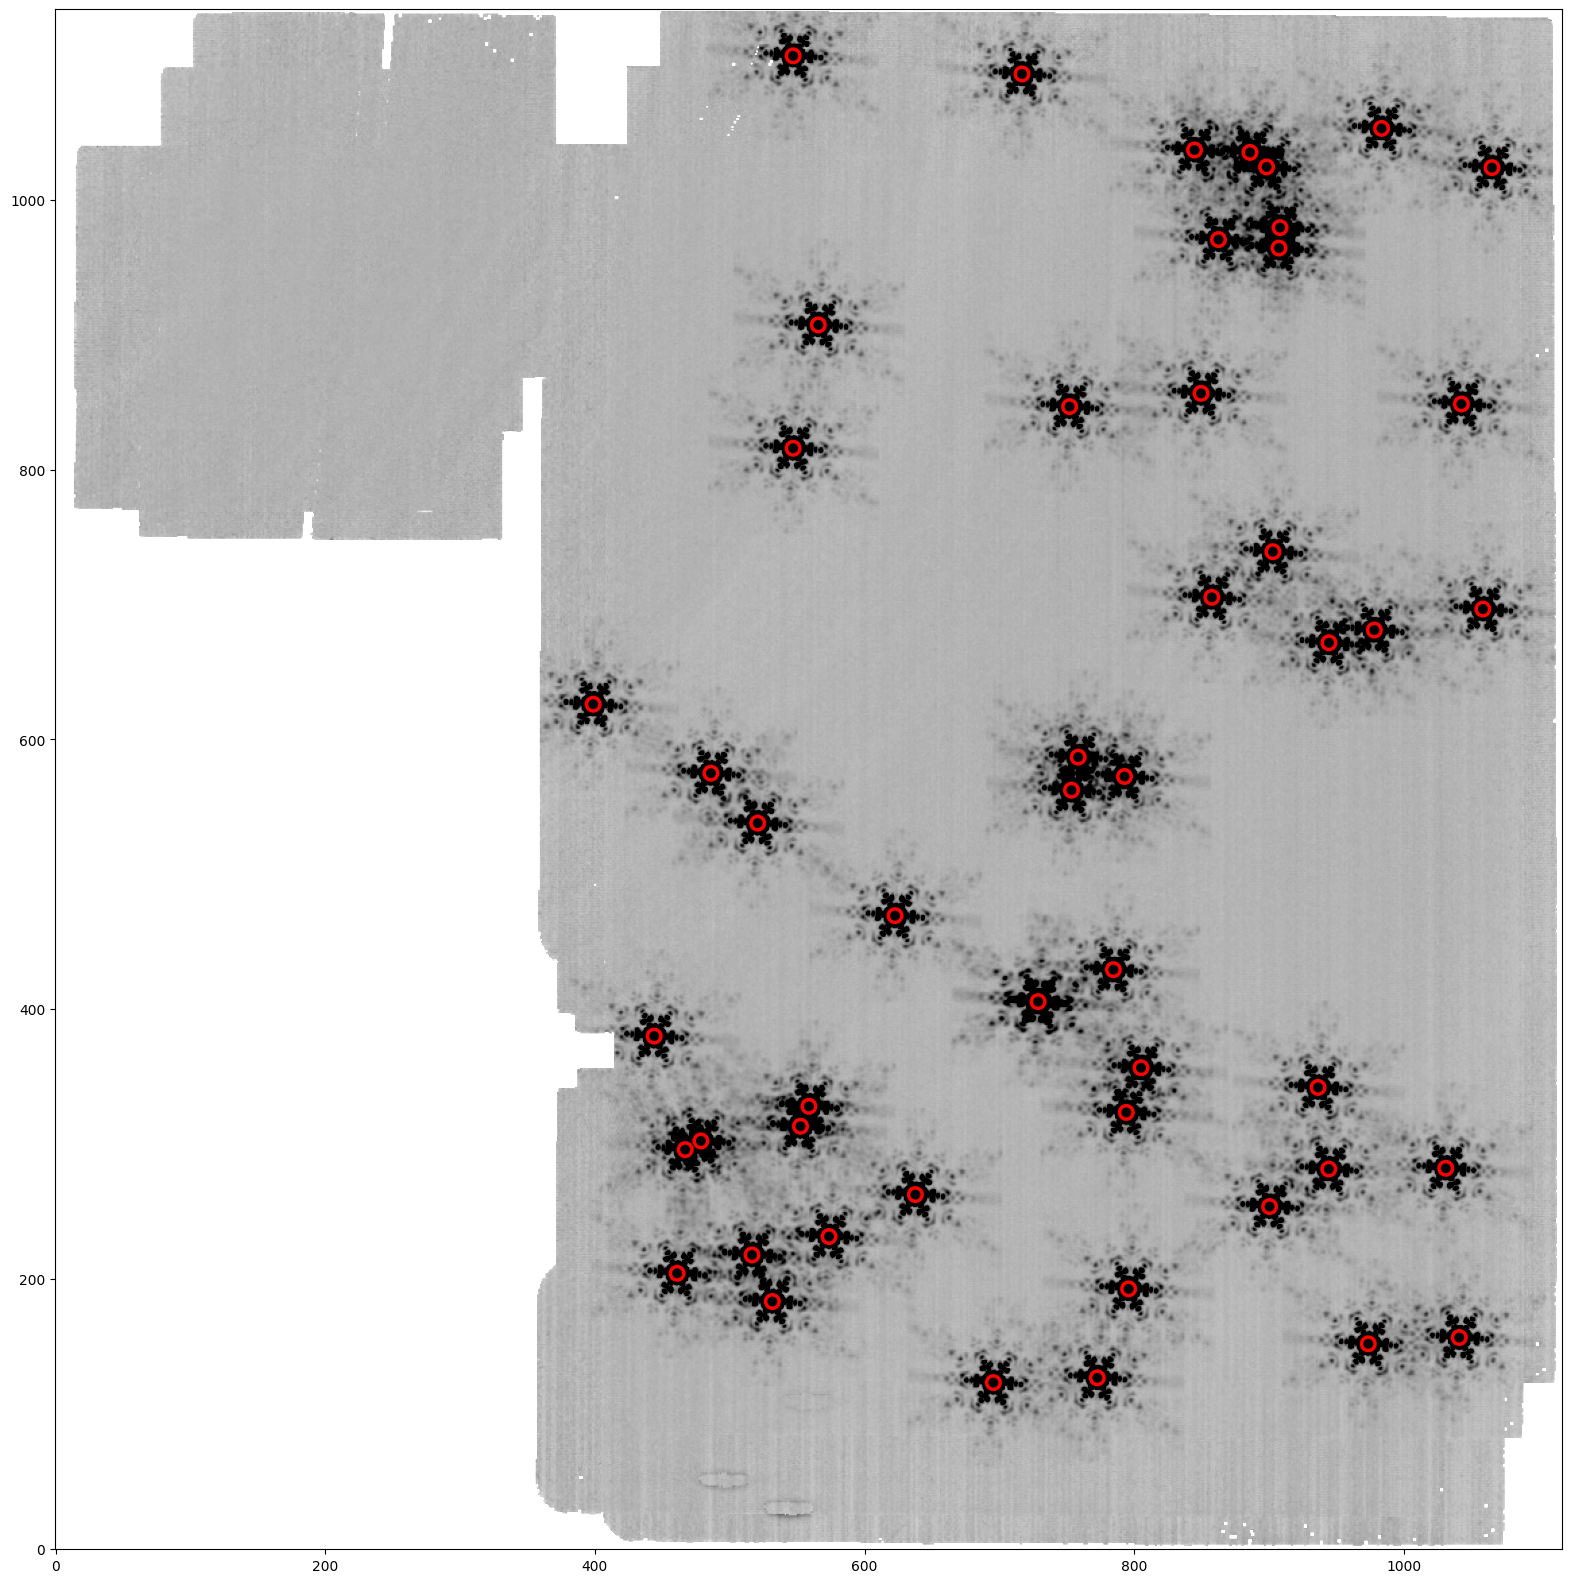

In [12]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='Greys', origin='lower', vmin=8,vmax=15)#, norm=norm)
apertures.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

#### Run photometry on apertures (with a specified annulus for background subtraction)

Set a specified annulus (inner and outer radii for the annulus).

Run photometry on aperture and annuli.

Subtract background values in annulus from aperture photometry.

Output should be a table of photometry values printed to the screen (full table has columns id, xcenter, ycenter, aperture_sum and the added columns annulus_median, aperture_bkg and aperture_sum_bkgsub). You can choose which columns you wish to see printed.

In [13]:
# set values for inner and outer annuli to collect background counts

inner_annulus = 10.
outer_annulus = 15.

# set up annulus for background
background_aper = CircularAnnulus(positions, r_in=inner_annulus, r_out=outer_annulus)

# perform photometry on apertures for targets and background annuli
phot_table = aperture_photometry(im.data, apertures)

# perform background subtraction with outlier rejection
bkg_median = []
bkg_mask = background_aper.to_mask(method='center')
bmask = bkg_mask[0]
for mask in bkg_mask:
    aper_data = bmask.multiply(data)
    aper_data = aper_data[mask.data > 0]
    
    # perform sigma-clipped median
    _, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)


# do calculations on background regions found in annuli
# Get average background per pixel
phot_table['annulus_median'] = bkg_median
# Get total background in the science aperture (per pixel * area in aperture)
phot_table['aperture_bkg'] = bkg_median * apertures.area
# subtract background in aperture from flux in aperture
phot_table['aperture_sum_bkgsub'] = phot_table['aperture_sum'] - phot_table['aperture_bkg']

# put aperture sum in pixel scale
phot_table['scaled_ap_sum_bkgsub'] = phot_table['aperture_sum_bkgsub'] * pixarea

#print(phot_table['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub','scaled_ap_sum_bkgsub'])

phot_table_sub = phot_table['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub','scaled_ap_sum_bkgsub']
phot_table_sub.pprint_all()

   aperture_sum      annulus_median      aperture_bkg    aperture_sum_bkgsub  scaled_ap_sum_bkgsub 
------------------ ------------------ ------------------ ------------------- ----------------------
36846.980686608986  14.93050765991211 1172.6393294686504  35674.341357140336 1.0145911449329346e-08
   37069.371547282 14.539774894714355 1141.9512498520983    35927.4202974299 1.0217888013441974e-08
 37146.21669492824 14.903438568115234 1170.5133279704403    35975.7033669578 1.0231619892694566e-08
  37299.3444963277 14.715289115905762 1155.7361045494847  36143.608391778216 1.0279372687810554e-08
37763.247353303275 14.600446701049805  1146.716402378685   36616.53095092459 1.0413873570656677e-08
 37583.06609537285 14.600446701049805  1146.716402378685   36436.34969299417 1.0362629370532855e-08
38118.595840084534  14.77898120880127 1160.7384698277917  36957.857370256745 1.0510948036340331e-08
 37312.37813455113  14.87005615234375 1167.8914791667708   36144.48665538436 1.0279622469150255e-08


#### Put x, y coordinates into RA and Dec using the wcs information from the files.
The output of the next block of code should be a table showing the x and y centroid positions as well as the associated RA and Dec values.

In [14]:
# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
sources_sub.pprint_all()

# add option to print out list of sources with flux values
outtable = 'sourcelist_phot_rate.txt'
sources.add_column(phot_table['aperture_sum'])
sources.add_column(phot_table['aperture_sum_bkgsub'])
sources.add_column(phot_table['scaled_ap_sum_bkgsub'])

    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ --------------------- -----------------------
 695.4768873849597 123.09345386140679 0.0008744196286825949   -0.014622459880034746
 772.5497139436839 126.62722936100566     359.9985202726622   -0.014306661462618709
 973.4985485352782 151.87781319201048    359.99242556199556   -0.012991469340025985
1040.9504131057192 156.51763105193604    359.99036944597395   -0.012667643711837574
 531.5670391216789  183.2162491709291  0.006062988925558933    -0.01321975197076472
 795.7620600240112  192.6182172262258     359.9979860007638   -0.012220389179595842
460.94604927202033 204.17190011221226  0.008285180075728076   -0.012767148706877365
 516.4969163945225 217.77212688417637  0.006618156878560576   -0.012200555784181426
 573.6221794709099  231.4100315182614  0.004902951754196733    -0.01162857019855531
  900.309094984966 253.64419081101315    359.99494400714025   -0.01006748808

#### Compare the RA and Dec positions used to create the simulated data to the values found in the output image.
Difference each set of RA and Dec coordinates in both the input list and the found coordinates, taking into account any angles close to 360/0 degrees. If the difference for both the RA and Dec are below a set tolerance, then the positions match. Take the matched positions and convert the differences from degrees to milli arcseconds, and output the RA and Dec positions as well as the differences. 

In [15]:
# Compare input RA, Dec to found RA, Dec
print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail')

deltara = []
deltadec = []

for i in np.arange(0,len(RA_sim)):
    for j in np.arange(0,len(ra)):
        ra_diff = 180 - abs(abs(RA_sim[i] - ra[j])-180)
        dec_diff = 180 - abs(abs(Dec_sim[i] - dec[j])-180)

        if ra_diff < 1e-5 and dec_diff < 1e-5:
            # put differences in milliarcseconds
            ra_diff = ra_diff * 3600000
            dec_diff = dec_diff * 3600000
            deltara.append(ra_diff)
            deltadec.append(dec_diff)

            if ra_diff < 30 and dec_diff < 30: 
                test = 'pass' 
            else: 
                test = 'fail'
            print('{:15.6f} {:15.6f} {:15.6f} {:15.6f} {:15.5e} {}'.format(ra[j], dec[j], ra_diff, dec_diff, 
                                                                        phot_table['scaled_ap_sum_bkgsub'][j], test))

       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail
     359.998760        0.013810       21.490203       26.459925     1.04122e-08 pass
       0.000281       -0.000993       21.570461       10.000211     1.02559e-08 pass
       0.006618       -0.012201       24.635237       19.599177     1.02796e-08 pass
     359.998520       -0.014307        9.818416       15.618735     1.02179e-08 pass
     359.998145       -0.007168       17.373535       15.963561     1.01523e-08 pass
       0.007351       -0.002369       22.256688        4.948993     1.02306e-08 pass
     359.997473        0.003672       24.252507       15.199052     1.03423e-08 pass
       0.008514       -0.001327       16.646003        8.076783     1.01656e-08 pass
       0.001089        0.007726       26.574335       17.752580     1.02737e-08 pass
     359.996643        0.011749       21.441394       19.618010     1.02591e-08 pass
       0.006966        0.009082       20.142817       12.176

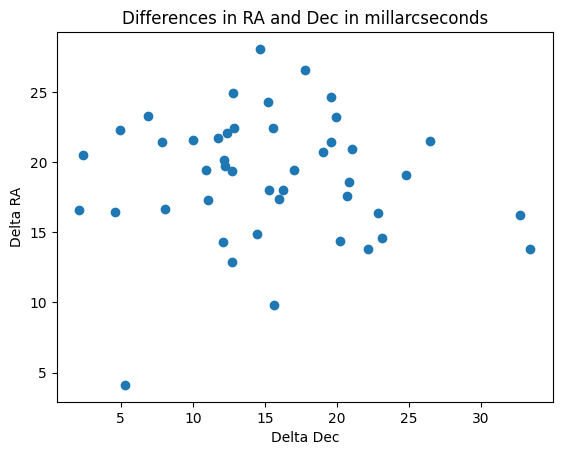

In [16]:
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in millarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltadec,deltara)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds

<a id="residual_ID"></a>
## Compare output RA and Dec to expected values

The output RA and Dec coordinates should match the input RA and Dec coordinates to within 1/10 of a PSF FWHM (~0.03 arcsec for F770W).

Output RA_Diff and Dec_diff above should be on order of 30 or fewer milliarcseconds.

Check to see if your surface brightness is roughly what you expected based on the input data.

[Top of Page](#title_ID)

### Check flux values against spatial coordinates

Another test that can be done is to plot the flux values against x and y values to check for any systmatic patterns. Previous testing has shown a spatial dependence of the flux with y values, such that there is a rise in surface brightness in the middle, and a drop at the image edges. A quick plot can show whether this problem is fixed or not. Prior to the resample step, there is no pattern, after the step, a pattern is clear. Just do this as a last check. If the scatter is not random, there may be a problem that needs to be checked. (Of course, this only works if you give an equivalent if not equal input count level to each input star.) If there is not an obvious rise in the middle (around y centroid pos of 550-600), then this test passes.

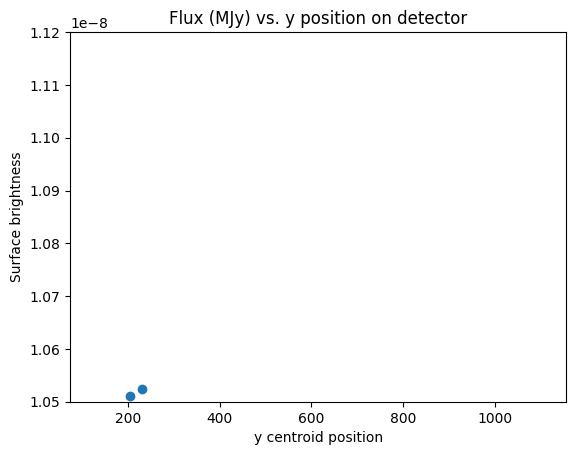

In [17]:
plt.title('Flux (MJy) vs. y position on detector')

plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('y centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['ycentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') 
plt.show()

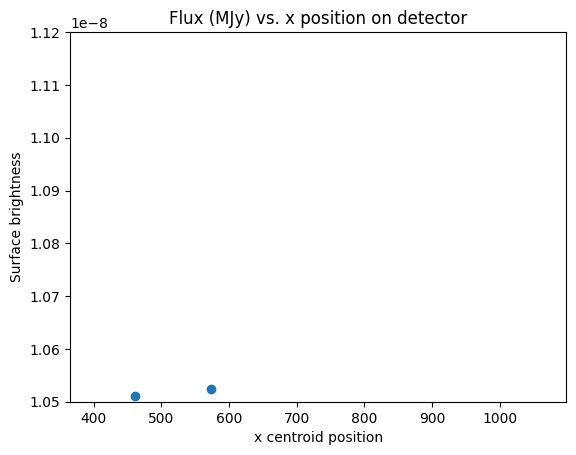

In [18]:
plt.title('Flux (MJy) vs. x position on detector')

plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('x centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['xcentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') #ylim=(30000,40000))
plt.show()

## Repeat prior tests with different scaling factor
Check previous tests with different scaling factor to see if the RA/Dec values still line up and the photometry gives consistent results.

In [19]:
# Grab all *.cal files and create a new association table.
callist = glob.glob('starfield*cal.fits')

# use asn_from_list to create association table
asn = asn_from_list.asn_from_list(callist, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_scaled_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_scaled_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])


In [20]:
# Run Calwebb_image3 on the association table
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 5.0  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 50 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom = 'shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True

ratio = 0.5 # Ratio of input to output pixel scale. A value of 0.5 means the output image would have 4 pixels 
            # sampling each input pixel.
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
#pipe3.tweakreg.skip = True
pipe3.tweakreg.use2dhist = use2dhist
pipe3.resample.pixel_scale_ratio = ratio
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3

image = pipe3.run('starfield_50star4ptdither_scaled_asnfile.json')
print('Image 3 pipeline finished.')

2022-10-06 05:35:31,708 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-10-06 05:35:31,709 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-10-06 05:35:31,711 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-10-06 05:35:31,712 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-10-06 05:35:31,714 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-10-06 05:35:31,715 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-10-06 05:35:31,716 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-10-06 05:35:31,947 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_scaled_asnfile.json',).


2022-10-06 05:35:31,953 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 5.0, 'snr_threshold': 50, 'sharplo': 0.2

2022-10-06 05:35:32,076 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-10-06 05:35:32,079 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2022-10-06 05:35:32,080 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2022-10-06 05:35:32,081 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-06 05:35:32,082 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-10-06 05:35:33,140 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-10-06 05:35:33,142 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 5.0, 'snr_threshold': 50, 'sharplo': 0.2, 'sharphi': 1.0, 'roundlo': -1.0, 'roundhi': 1.0, 'brightest': 200, 'peakmax': None, 'bkg_boxsize': 400, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 2.0, 'use2dhist': False, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'abs_refcat': '', 'save_abs_catalog': False, 'abs_minobj': 15, 'abs_searchrad': 6.0, 'abs_use2dhist': True, 'abs_separation': 0.1, 'abs_tolerance': 0.7, 'abs_fitgeometry': 'rshift', 'abs_nclip': 3, 'abs_sigma': 3.0}


2022-10-06 05:35:33,310 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:35:33,486 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:35:33,666 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:35:33,850 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:35:34,029 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:35:34,208 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:35:34,394 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2022-10-06 05:35:34,577 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 200 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2022-10-06 05:35:34,599 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:34,599 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2022-10-06 05:35:34,600 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-10-06 05:35:34,623 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:35:34,623 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:35:34,648 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:35:34,648 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:35:34,671 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:35:34,672 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:35:34,696 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:35:34,697 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:35:34,719 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:35:34,720 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:35:34,744 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:35:34,745 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:35:34,767 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2022-10-06 05:35:34,768 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2022-10-06 05:35:34,792 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2022-10-06 05:35:34,793 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2022-10-06 05:35:34,793 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:34,793 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:35:34,794 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-10-06 05:35:34.793926


2022-10-06 05:35:34,794 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.8.0


2022-10-06 05:35:34,794 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:35:35,028 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2022-10-06 05:35:35,034 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:35:35,154 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:35:35,156 - stpipe.Image3Pipeline.tweakreg - INFO - Found 73 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:35:35,157 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:35:35,159 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:35:35,159 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -1.04064e-05  YSH: -9.45202e-06


2022-10-06 05:35:35,160 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:35,160 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.001818   FIT MAE: 0.00145054


2022-10-06 05:35:35,160 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 72 objects.


2022-10-06 05:35:35,198 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-10-06 05:35:35,324 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:35:35,325 - stpipe.Image3Pipeline.tweakreg - INFO - Found 53 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2022-10-06 05:35:35,326 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:35:35,328 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2022-10-06 05:35:35,328 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0416528  YSH: -0.0266671


2022-10-06 05:35:35,328 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:35,329 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.316475   FIT MAE: 0.218744


2022-10-06 05:35:35,329 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 53 objects.


2022-10-06 05:35:35,366 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:35:35,493 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:35:35,495 - stpipe.Image3Pipeline.tweakreg - INFO - Found 55 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:35:35,495 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:35:35,497 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:35:35,497 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.050707  YSH: -0.00657054


2022-10-06 05:35:35,498 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:35,498 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.317766   FIT MAE: 0.222451


2022-10-06 05:35:35,498 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 55 objects.


2022-10-06 05:35:35,533 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-10-06 05:35:35,653 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:35:35,655 - stpipe.Image3Pipeline.tweakreg - INFO - Found 60 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2022-10-06 05:35:35,655 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:35:35,657 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2022-10-06 05:35:35,657 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0119643  YSH: 0.0134823


2022-10-06 05:35:35,658 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:35,658 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.334214   FIT MAE: 0.223583


2022-10-06 05:35:35,658 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 60 objects.


2022-10-06 05:35:35,693 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:35:35,813 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:35:35,814 - stpipe.Image3Pipeline.tweakreg - INFO - Found 60 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:35:35,815 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:35:35,817 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:35:35,817 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.00110832  YSH: 0.0130964


2022-10-06 05:35:35,817 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:35,818 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.315695   FIT MAE: 0.201238


2022-10-06 05:35:35,818 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 60 objects.


2022-10-06 05:35:35,853 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-10-06 05:35:36,197 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:35:36,199 - stpipe.Image3Pipeline.tweakreg - INFO - Found 54 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2022-10-06 05:35:36,199 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:35:36,201 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2022-10-06 05:35:36,201 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.0142013  YSH: -0.00953756


2022-10-06 05:35:36,202 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:36,202 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.320146   FIT MAE: 0.220856


2022-10-06 05:35:36,202 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 54 objects.


2022-10-06 05:35:36,237 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2022-10-06 05:35:36,359 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-10-06 05:35:36,361 - stpipe.Image3Pipeline.tweakreg - INFO - Found 53 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2022-10-06 05:35:36,361 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-10-06 05:35:36,363 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2022-10-06 05:35:36,363 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00190551  YSH: -0.0279355


2022-10-06 05:35:36,364 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-10-06 05:35:36,364 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.30067   FIT MAE: 0.204943


2022-10-06 05:35:36,364 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 53 objects.


2022-10-06 05:35:36,400 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:35:36,400 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-10-06 05:35:36.400028


2022-10-06 05:35:36,401 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.606102


2022-10-06 05:35:36,401 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-10-06 05:35:36,556 - stpipe.Image3Pipeline.tweakreg - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:35:36,668 - stpipe.Image3Pipeline.tweakreg - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:35:36,679 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:35:36,679 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:35:36,886 - stpipe.Image3Pipeline.tweakreg - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-10-06 05:35:36,897 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:35:36,897 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:35:37,009 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:35:37,009 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:35:37,116 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:35:37,117 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:35:37,221 - stpipe.Image3Pipeline.tweakreg - WARNING - Failed to update 'meta.wcsinfo' with FITS SIP approximation. Reported error is:


2022-10-06 05:35:37,222 - stpipe.Image3Pipeline.tweakreg - WARNING - "Failed to achieve required error tolerance"


2022-10-06 05:35:37,234 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-10-06 05:35:37,485 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-10-06 05:35:37,487 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-10-06 05:35:37,709 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:35:37,710 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-10-06 05:35:37.709380


2022-10-06 05:35:37,710 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:35:37,710 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'match'


2022-10-06 05:35:37,711 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-10-06 05:35:37,711 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-10-06 05:35:37,711 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:35:37,712 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-10-06 05:35:49,289 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0104564


2022-10-06 05:35:49,291 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00699186


2022-10-06 05:35:49,291 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0247774


2022-10-06 05:35:49,292 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0148887


2022-10-06 05:35:49,292 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0142996


2022-10-06 05:35:49,292 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0177906


2022-10-06 05:35:49,293 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00264731


2022-10-06 05:35:49,294 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0


2022-10-06 05:35:49,294 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:35:49,294 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-10-06 05:35:49.294397


2022-10-06 05:35:49,295 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:11.585017


2022-10-06 05:35:49,295 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-10-06 05:35:49,328 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-10-06 05:35:49,545 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-10-06 05:35:49,547 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None, 'in_memory': False}


2022-10-06 05:35:49,554 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 8 inputs


2022-10-06 05:35:49,554 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter kernel: square


2022-10-06 05:35:49,555 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:35:49,555 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter fillval: INDEF


2022-10-06 05:35:49,555 - stpipe.Image3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm


2022-10-06 05:35:49,741 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:50,354 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:50,641 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:35:50,646 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:51,403 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:51,678 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:35:51,683 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:52,430 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:52,710 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:35:52,714 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:53,470 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:53,750 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:35:53,755 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:54,518 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:54,797 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:35:54,802 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:55,553 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:55,830 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:35:55,834 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:56,599 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:56,879 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_outlier_i2d.fits saved to file


2022-10-06 05:35:56,884 - stpipe.Image3Pipeline.outlier_detection - INFO - 1 exposures to drizzle together


2022-10-06 05:35:57,630 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:35:57,910 - stpipe.Image3Pipeline.outlier_detection - INFO - Exposure starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_outlier_i2d.fits saved to file


2022-10-06 05:36:04,099 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2022-10-06 05:36:04,191 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:04,774 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:05,065 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:05,787 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:06,111 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:06,842 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:07,165 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:07,899 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:08,217 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:08,946 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:09,264 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:10,005 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:10,325 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:11,096 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:11,701 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:335: RuntimeWarning: invalid value encountered in multiply
  blotted_median.err *= 0.0  # None



2022-10-06 05:36:12,455 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1119)


2022-10-06 05:36:12,669 - stpipe.Image3Pipeline.outlier_detection - INFO - Flagging outliers


2022-10-06 05:36:12,840 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:12,859 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:12,874 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 564 (0.05%)


2022-10-06 05:36:13,070 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:13,089 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:13,103 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 571 (0.05%)


2022-10-06 05:36:13,295 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:13,314 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:13,327 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 805 (0.08%)


2022-10-06 05:36:13,528 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:13,546 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:13,560 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 933 (0.09%)


2022-10-06 05:36:13,751 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:13,776 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:13,791 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 439 (0.04%)


2022-10-06 05:36:13,984 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:14,002 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:14,016 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 404 (0.04%)


2022-10-06 05:36:14,434 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:14,453 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:14,466 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 528 (0.05%)


2022-10-06 05:36:14,659 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:440: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-10-06 05:36:14,677 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:449: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-10-06 05:36:14,690 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 494 (0.05%)


2022-10-06 05:36:14,953 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:36:15,230 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:36:15,505 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:36:15,787 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:36:16,062 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:36:16,337 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:36:16,609 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2022-10-06 05:36:16,884 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2022-10-06 05:36:16,884 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-10-06 05:36:17,083 - stpipe.Image3Pipeline - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:419: ResourceWarning: unclosed file <_io.BufferedReader name='starfield_50star4ptdither_scaled_asnfile_starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_a3001_blot.fits'>
  gc.collect()



2022-10-06 05:36:17,095 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-10-06 05:36:17,097 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 0.5, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-06 05:36:17,118 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-06 05:36:17,142 - stpipe.Image3Pipeline.resample - INFO - Driz parameter kernel: square


2022-10-06 05:36:17,142 - stpipe.Image3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2022-10-06 05:36:17,142 - stpipe.Image3Pipeline.resample - INFO - Driz parameter fillval: INDEF


2022-10-06 05:36:17,143 - stpipe.Image3Pipeline.resample - INFO - Driz parameter weight_type: ivm


2022-10-06 05:36:17,313 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_scaled_combined.fits


2022-10-06 05:36:17,944 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-10-06 05:36:18,507 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:19,395 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:20,289 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:21,180 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:22,075 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:22,962 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:23,847 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:24,739 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:24,915 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-10-06 05:36:25,466 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:26,411 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:27,353 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:28,275 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:29,190 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:30,100 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:31,024 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:31,951 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:32,140 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-10-06 05:36:32,705 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:33,628 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:34,549 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:35,460 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:36,371 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:37,276 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:38,175 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:39,112 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:39,300 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-10-06 05:36:39,854 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:40,768 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:41,674 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:42,578 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:43,489 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:44,392 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:45,293 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:46,195 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1119)


2022-10-06 05:36:46,381 - stpipe.Image3Pipeline.resample - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/resample/resample.py:308: RuntimeWarning: divide by zero encountered in reciprocal
  output_variance = np.reciprocal(inverse_variance_sum)



2022-10-06 05:36:46,422 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021885075 -0.020259823 0.024958525 0.014762852 359.990641209 0.017774402 359.987567759 -0.017248273


2022-10-06 05:36:46,874 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_scaled_combined_i2d.fits


2022-10-06 05:36:46,874 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-10-06 05:36:47,132 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1119) from starfield_50star4ptdither_scaled_combined_i2d.fits>,).


2022-10-06 05:36:47,134 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 1000, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 25, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-10-06 05:36:47,152 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2022-10-06 05:36:47,162 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file: /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2022-10-06 05:36:47,163 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2022-10-06 05:36:47,163 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2022-10-06 05:36:47,163 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2022-10-06 05:36:47,164 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-10-06 05:36:47,217 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2022-10-06 05:36:47,295 - stpipe.Image3Pipeline.source_catalog - INFO - Background could not be estimated in meshes. Using the entire unmasked array for background estimation: bkg_boxsize=(1142, 1119).


2022-10-06 05:36:47,521 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 278 sources


2022-10-06 05:36:47,902 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_scaled_combined_cat.ecsv


2022-10-06 05:36:48,028 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_scaled_combined_segm.fits


2022-10-06 05:36:48,030 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_scaled_combined_segm.fits


2022-10-06 05:36:48,030 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-10-06 05:36:48,032 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


In [21]:
# Read in the combined data file and list of coordinates

im2 = ImageModel('starfield_50star4ptdither_scaled_combined_i2d.fits')
#get pixel scale
pixarea2 = im2.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea2)
print('Ratio of pixel area scales: original/new scale', pixarea / pixarea2)

# read in text file with RA and Dec input coordinates
RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

# put RA and Dec into floats
RA_sim = RA_in.astype(float)
Dec_sim = Dec_in.astype(float)


# pull out data portion of input file
data2 = im2.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data2, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 7.1100902380771e-14
Ratio of pixel area scales: original/new scale 4.0


Image mean, median and std 10.159399 10.824437 46.724823


In [22]:
# Run DAOStarFinder to find sources in image
pixel_ratio = math.sqrt(pixarea / pixarea2) # ratio of pixel area scales in single dimension (sqrt of area)

ap_radius2 = ap_radius * pixel_ratio  # radius for aperture for centroiding and photometry
print('New aperture radius', ap_radius2)

daofind = DAOStarFinder(fwhm=3.0*pixel_ratio, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources2 = daofind(data2)    
#print(sources2['xcentroid','ycentroid','peak'])   
sources2.pprint_all()

# Create apertures for x,y positions
positions2 = tuple(zip(sources2['xcentroid'], sources2['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures2 = CircularAperture(positions2, r=ap_radius2)


New aperture radius 10.0


 id     xcentroid          ycentroid          sharpness       roundness1        roundness2      npix sky        peak              flux                mag        
--- ------------------ ------------------ ------------------ ------------ --------------------- ---- --- ----------------- ------------------ -------------------
  1  695.8148913545083 122.66066510850565 0.5583964985271366  0.059600648   0.04211940686311831   49 0.0 2710.330322265625  9.637730598449707 -2.4599369559707855
  2  772.8912378334629 126.06100015700252 0.5603930692106679  0.020375542    0.0532789656908137   49 0.0 2806.707275390625  10.00119686126709 -2.5001299397851358
  3  973.7718874406253  151.3128757392191 0.5312807936151035  -0.02924974  0.046551988849745915   49 0.0  2616.81298828125   9.65421199798584 -2.4617920782785014
  4 1041.3209618605656   155.904950275729 0.5849902854765686 -0.015508978   0.00574869523271661   49 0.0  2843.92138671875   9.81488037109375 -2.4797125263987785
  5  531.9013491162301  182.

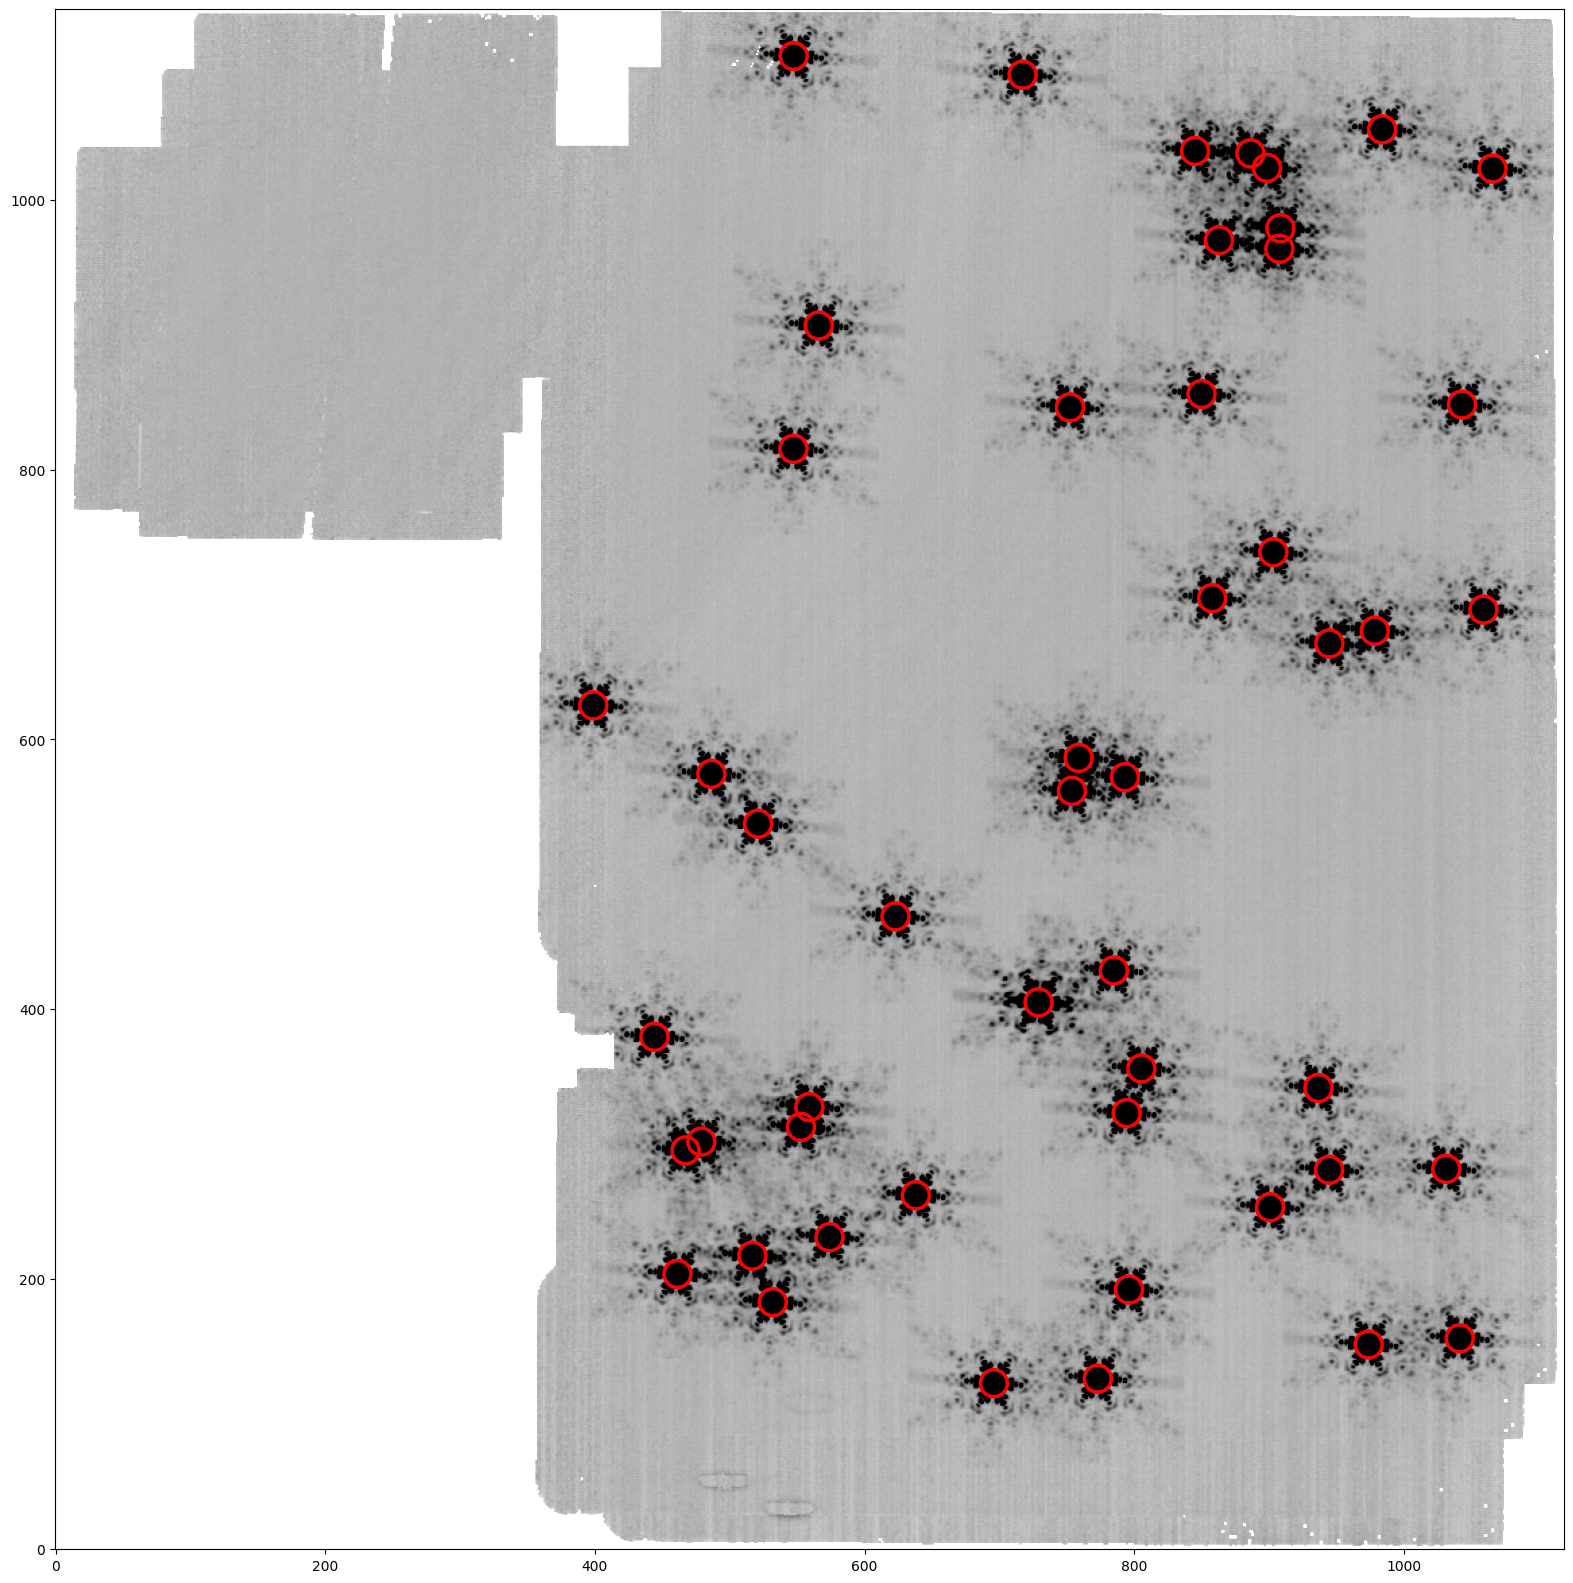

In [23]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data2, cmap='Greys', origin='lower', vmin=8,vmax=15)#, norm=norm)
apertures2.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

In [24]:
# set values for inner and outer annuli to collect background counts

inner_annulus2 = inner_annulus * pixel_ratio
outer_annulus2 = outer_annulus * pixel_ratio

# set up annulus for background
background_aper2 = CircularAnnulus(positions2, r_in=inner_annulus2, r_out=outer_annulus2)

# perform photometry on apertures for targets and background annuli
phot_table2 = aperture_photometry(im2.data, apertures2)

# perform background subtraction with outlier rejection
bkg_median = []
bkg_mask2 = background_aper2.to_mask(method='center')
bmask2 = bkg_mask2[0]
for mask in bkg_mask2:
    aper_data = bmask2.multiply(data2)
    aper_data = aper_data[mask.data > 0]
    
    # perform sigma-clipped median
    _, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)


# do calculations on background regions found in annuli
# Get average background per pixel
phot_table2['annulus_median'] = bkg_median
# Get total background in the science aperture (per pixel * area in aperture)
phot_table2['aperture_bkg'] = bkg_median * apertures2.area
# subtract background in aperture from flux in aperture
phot_table2['aperture_sum_bkgsub'] = phot_table2['aperture_sum'] - phot_table2['aperture_bkg']
# put aperture sum in pixel scale
phot_table2['scaled_ap_sum_bkgsub'] = phot_table2['aperture_sum_bkgsub'] * pixarea2


In [25]:
phot_table2_sub = phot_table2['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub','scaled_ap_sum_bkgsub']
phot_table2_sub.pprint_all()

   aperture_sum      annulus_median      aperture_bkg    aperture_sum_bkgsub  scaled_ap_sum_bkgsub 
------------------ ------------------ ------------------ ------------------- ----------------------
 47507.53381748896 11.294155597686768  3548.163625419279  43959.370192069684  3.125550888746521e-09
 48189.15561808404 11.301733493804932  3550.544291696728   44638.61132638731  3.173845546330643e-09
47175.635595679836 11.301733493804932  3550.544291696728   43625.09130398311  3.101783358156725e-09
47229.582564642435 11.300782680511475  3550.245584890962  43679.336979751475 3.1056402746541104e-09
 47662.87147774041 11.300673484802246 3550.2112800471705  44112.660197693236  3.136449946472309e-09
 48372.84259743671 11.301979064941406 3550.6214401445563   44822.22115729216 3.1869003709939584e-09
 48305.22905069726   11.3015718460083 3550.4935085436914   44754.73554215357 3.1821020828598833e-09
47112.369975534704 11.301733493804932  3550.544291696728  43561.825683837975  3.097285115474727e-09


In [26]:
# using wcs info from images, put coordinates into RA, Dec
ra2, dec2 = im2.meta.wcs(sources2['xcentroid'], sources2['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra2)
dec_col = Column(name='Dec', data=dec2)
sources2.add_column(ra_col)
sources2.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources2['xcentroid', 'ycentroid', 'RA', 'Dec']) 
sources2_sub = sources2['xcentroid', 'ycentroid', 'RA', 'Dec']
sources2_sub.pprint_all()

# add option to print out list of sources with flux values
outtable = 'sourcelist_phot_rate.txt'
sources2.add_column(phot_table2['aperture_sum'])
sources2.add_column(phot_table2['aperture_sum_bkgsub'])
sources2.add_column(phot_table2['scaled_ap_sum_bkgsub'])

    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 695.8148913545083 122.66066510850565  0.0008760484976707871   -0.014625448199400289
 772.8912378334629 126.06100015700252     359.99852143445634    -0.01431373263947474
 973.7718874406253  151.3128757392191      359.9924288183528   -0.012998684406977956
1041.3209618605656   155.904950275729       359.990369592624   -0.012676061343637603
 531.9013491162301  182.7283392411226   0.006064582733750613    -0.01322444067942545
 796.0540974759986   192.118463451694      359.9979888591047   -0.012225554880901636
 461.2188136154165 203.64188724843325    0.00828854804522523   -0.012773294258763215
 516.7643604116995 217.23363101359183   0.006621665180805069   -0.012206975810126251
 573.9474940640577   230.854399521725   0.004904639172453884    -0.01163536000620962
 900.6027137646884 253.14962709013565      359.9949468309532   -0

In [27]:
# Compare input RA, Dec to found RA, Dec
print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail')

deltara2 = []
deltadec2 = []

for i in np.arange(0,len(RA_sim)):
    for j in np.arange(0,len(ra2)):
        ra_diff = 180 - abs(abs(RA_sim[i] - ra2[j])-180)
        dec_diff = 180 - abs(abs(Dec_sim[i] - dec2[j])-180)

        if ra_diff < 1e-5 and dec_diff < 1e-5:
            # put differences in milliarcseconds
            ra_diff = ra_diff * 3600000
            dec_diff = dec_diff * 3600000
            deltara2.append(ra_diff)
            deltadec2.append(dec_diff)
            if ra_diff < 30 and dec_diff < 30: 
                test = 'pass' 
            else: 
                test = 'fail'
            print('{:15.6f} {:15.6f} {:15.6f} {:15.6f} {:15.6e} {}'.format(ra2[j], dec2[j], ra_diff, dec_diff, 
                                                                        phot_table2['scaled_ap_sum_bkgsub'][j], test))

       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail
     359.998761        0.013800       19.602067        9.717291    3.104811e-09 pass
     359.997495        0.013856       14.174020        1.061324    3.319911e-09 pass
       0.000284       -0.000999       11.893004        9.975853    3.127542e-09 pass
       0.006622       -0.012207       12.005349        3.512916    3.097285e-09 pass
     359.998521       -0.014314        5.635957        9.837502    3.173846e-09 pass
     359.998149       -0.007173        4.421080        4.634775    3.172676e-09 pass
       0.007354       -0.002373        9.562780       12.405465    3.186303e-09 pass
     359.997477        0.003664       12.461262       15.184377    3.130726e-09 pass
       0.008517       -0.001332        7.763090       10.988133    3.112988e-09 pass
       0.001092        0.007718       14.222125       10.191643    3.059655e-09 pass
     359.996646        0.011743        9.981968        3.389

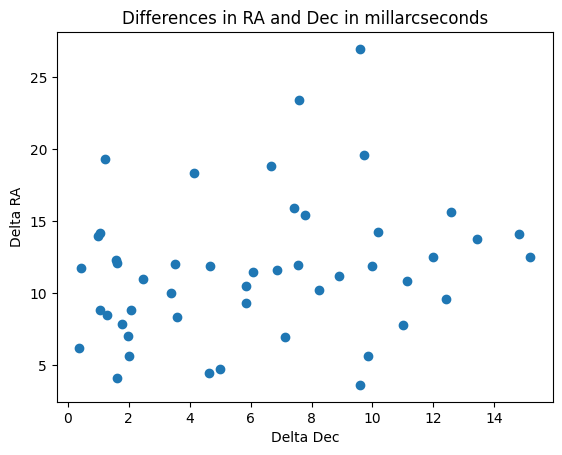

In [28]:
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in millarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltadec2,deltara2)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds

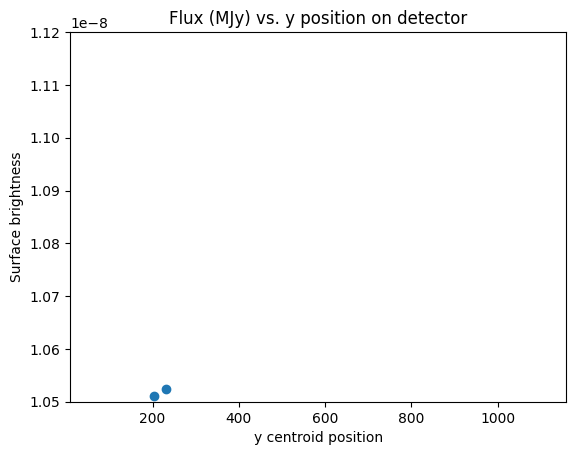

In [29]:
# Compare photometry between the original and scaled images
plt.title('Flux (MJy) vs. y position on detector')
#plt.ylim(33500,39000) # help weed out sources that were erroneously 'hits' (bad pixels, cosmic rays, etc)
plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('y centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['ycentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') 
plt.plot(sources2['ycentroid']/2, phot_table2['scaled_ap_sum_bkgsub'], marker='+',linestyle='') 

plt.show()

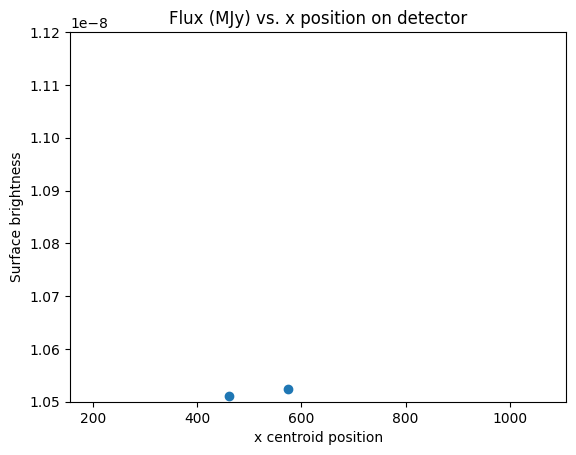

In [30]:
# Compare photometry between the original and scaled images
plt.title('Flux (MJy) vs. x position on detector')
#plt.ylim(33500,39000) # help weed out sources that were erroneously 'hits' (bad pixels, cosmic rays, etc)
plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('x centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['xcentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') 
plt.plot(sources2['xcentroid']/2, phot_table2['scaled_ap_sum_bkgsub'], marker='+',linestyle='') 

plt.show()

In [31]:
# Get some statistics of the two sets of fluxes for comparison
# get stddev from mean for each of the measurements in percentage

photdata1 = phot_table['scaled_ap_sum_bkgsub']
photdata2 = phot_table2['scaled_ap_sum_bkgsub']

std1 = np.std(photdata1)
mean1 = np.mean(photdata1)

std2 = np.std(photdata2)
mean2 = np.mean(photdata2)

per1 = std1 / mean1 * 100
per2 = std2 / mean2 * 100

print('Mean and standard deviation of original scale data', mean1, std1)
print('Mean and standard deviation of new scale data', mean2, std2)

print('The standard deviation from the mean (as a percentage) for the original scale flux data, is', per1)
print('The standard deviation from the mean (as a percentage) for the new scaled flux data, is', per2)

# Compare stats on overall image values, not just phot values

# im is the original scaled image and im2 is the rescaled image

# print stats on original input image
mean1, median1, std1 = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Original image mean, median and std',mean1, median1, std1)

# print stats on rescaled input image
mean2, median2, std2 = sigma_clipped_stats(data2, sigma=200.0, maxiters=5)  # default sigma=3
print('Rescaled image mean, median and std',mean2, median2, std2)

ratio_mean = mean1 / mean2
#ratio_median = median1 / median2

print('The ratio of the mean of the two images is: ', ratio_mean)
#print('The ratio of the median of the two images is: ', ratio_median)

Mean and standard deviation of original scale data 1.0439144563964573e-08 1.1809115077171173e-09
Mean and standard deviation of new scale data 3.224594325046856e-09 3.925205294975616e-10
The standard deviation from the mean (as a percentage) for the original scale flux data, is 11.312339823260684
The standard deviation from the mean (as a percentage) for the new scaled flux data, is 12.17271042278653
Original image mean, median and std 10.161678 10.829916 46.34863
Rescaled image mean, median and std 10.159399 10.824437 46.724823
The ratio of the mean of the two images is:  1.0002244


### Passing criteria
If all RA/Dec matches have a 'pass' in the table for both original and scaled images, the fluxes for both the original data set and the scaled data set are roughly equal and the mean fluxes are nearly equivalent, then the notebook passes. The ratio printed of the means of the two images should be approximately 1.

<a id="about_ID"></a>
## About this Notebook
**Author:** M. Cracraft, Senior Staff Scientist, INS/MIRI
<br>**Updated On:** 04/02/2021 to add in testing the 'ratio' scaling option in resample.

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 